# Experiments with $\beta$-Variational AutoEncoder with $\beta$ =10

## Setup

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import pandas as pd
from IPython.display import display

from torchvision.utils import make_grid
from torchvision.transforms.transforms import ToPILImage, ToTensor

from google.colab import drive
import os
import pickle

import numpy as np
import copy
import sys
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import DataLoader, random_split, ConcatDataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tnrange

 ## Training and evaluation functions

 ## Training and evaluation functions VAE

In [ ]:
def train_VAE_model(model, train_loader,val_loader, test_loader, VAE_criterion,eval_criterions, optimizer, device, epochs, VAE_likelihood, beta, L, fold):
    outputs = []

    average_recons_losses = []  # List to store average reconstruction losses
    average_kld_losses = []     # List to store average KLD losses
    average_vae_losses = []         # List to store average total losses
    average_vae_val_losses = []
    average_recons_val_losses = []
    average_kld_val_losses = []
    average_val_losses = []

    for epoch in range(epochs):
        model.train()
        total_vae_loss = 0.0
        total_recons_loss = 0.0
        total_kld_loss = 0.0
        for images, _ in train_loader:
            x_in = images.view(images.size(0), -1).to(device)
            z_mu, z_logvar, z_samples, x_out  = model(x_in, L)
            recons_loss, kld_loss, vae_loss = VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta)
            optimizer.zero_grad()
            vae_loss.backward()
            optimizer.step()
            total_recons_loss += recons_loss.item()
            total_kld_loss += kld_loss.item()
            total_vae_loss += vae_loss.item()

        average_recons_loss = total_recons_loss / len(train_loader)
        average_kld_loss = total_kld_loss / len(train_loader)
        average_vae_loss = total_vae_loss / len(train_loader)

        average_recons_losses.append(average_recons_loss)
        average_kld_losses.append(average_kld_loss)
        average_vae_losses.append(average_vae_loss)


        print(f'Train Fold/Epoch: {fold + 1}/{epoch + 1}, Training Loss:{average_vae_loss:.6f}, Training Recons Loss: {average_recons_loss:.6f}, Training KLD Loss: {average_kld_loss:.6f}')


        # Validation phase

        average_loss, average_vae_val_loss, average_recons_val_loss, average_kld_val_loss = eval_VAE_model(fold, model, val_loader, eval_criterions, VAE_likelihood, beta, L, device)
        average_loss_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in average_loss.items()}
        average_vae_val_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in average_vae_val_loss.items()}
        average_recons_val_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in average_recons_val_loss.items()}
        average_kld_val_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in average_kld_val_loss.items()}


        average_val_losses.append(average_loss_0)
        average_vae_val_losses.append(average_vae_val_losses_1)
        average_recons_val_losses.append(average_recons_val_losses_2)
        average_kld_val_losses.append(average_kld_val_losses_3)

        print(f'Validation Fold/Epoch: {fold + 1}/{epoch + 1},  Validation Loss: {average_loss_0}, Validation VAE Loss: {average_vae_val_losses_1}, Validation Recons Loss: {average_recons_val_losses_2}, Validation KLD Loss: {average_kld_val_losses_3}')



        outputs.append((epoch, x_in, x_out))


    return outputs, average_vae_losses, average_recons_losses, average_kld_losses, average_val_losses, average_vae_val_losses, average_recons_val_losses, average_kld_val_losses

### Visualize reconstructions function VAE

In [ ]:
def VAE_visualize_original_images(test_loader, img_shape, num_samples=10, figure_size=(8, 2)):
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_features = batch_features.view(-1, img_shape[0] * img_shape[1])
            break

    plt.figure(figsize=figure_size)
    plt.gray()

    plt.suptitle('Visualizing Original Images', fontsize=12)

    for i in range(num_samples):
        ax = plt.subplot(2, num_samples, i + 1)
        # Check if there is only one image in the batch
        if len(batch_features) == 1:
            plt.imshow(batch_features[0].numpy().reshape(img_shape))
        else:
            plt.imshow(batch_features[i].numpy().reshape(img_shape))
        plt.axis('off')

    plt.show()
def VAE_visualize_reconstructions(model, test_loader, img_shape, L, device, num_samples=10, fold_index=None, figure_size=(8, 2)):
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_features = batch_features.to(device)
            x_in = batch_features.view(batch_features.size(0), -1)
            z_mu, z_logvar, z_samples, x_out = model(x_in, L)
            break

    plt.figure(figsize=figure_size)
    plt.gray()

    for i, (item_in, item_out) in enumerate(zip(x_in.cpu().numpy(), x_out.cpu().numpy())):
        if i >= num_samples:
            break
        # Plot original image
        if fold_index == 0:
          plt.subplot(2, num_samples, i + 1)
          item_in = item_in.reshape(img_shape)
          plt.imshow(item_in)
          plt.axis('off')

        # Plot reconstructed image for all folds
        plt.subplot(2, num_samples, num_samples + i + 1)
        item_out = item_out.reshape(img_shape)
        plt.imshow(item_out)
        plt.axis('off')

    plt.show()
img_shape = (28, 28)

### Evaluation functions VAE

In [ ]:
def eval_VAE_model(fold, model, test_loader, criterions, VAE_likelihood, beta, L, device):
    model.eval()
    criterion_names = list(criterions.keys())

    average_vae_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}
    average_recons_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}
    average_kld_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}

    average_total_loss = {criterion_name: 0.0 for criterion_name in criterion_names}


    for name, criterion in criterions.items():
        total_recons_loss = 0.0
        total_kld_loss = 0.0
        total_vae_loss = 0.0

        total_loss = 0.0

        for (images, _) in test_loader:
            #x_in = Variable(images.view(images.size(0), -1))
            x_in = images.view(images.size(0), -1).to(device)
            z_mu, z_logvar, z_samples, x_out = model(x_in, L)
            x_out_flat = x_out.view(x_in.size()).to(device)

            loss = criterion(x_out_flat , x_in)

            recons_loss, kld_loss, vae_loss = VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta)

            total_recons_loss += recons_loss.item()
            total_kld_loss += kld_loss.item()
            total_vae_loss += vae_loss.item()

            total_loss += loss.item()

        # Calculate the average loss for this criterion
        average_recons_loss = total_recons_loss / len(test_loader)
        average_kld_loss = total_kld_loss / len(test_loader)
        average_vae_loss = total_vae_loss / len(test_loader)

        average_loss = total_loss / len(test_loader)

        # Update the dictionaries with the average values
        average_vae_val_loss[name] = average_vae_loss
        average_recons_val_loss[name] = average_recons_loss
        average_kld_val_loss[name] = average_kld_loss

        average_total_loss[name] = average_loss

    return average_total_loss, average_vae_val_loss, average_recons_val_loss, average_kld_val_loss


## Model definitions: Pytorch Classes

## Variational Autoencoder

Code Regis Djaha

In [ ]:
# Encoder class used in VAE below
# Note the forward pass, where we compute the mean and logvariance of the latent variable
class Encoder(nn.Module):
    def __init__(self, D_x, D_z, n_layers, activation):
        super(Encoder, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        hidden_sizes = [D_x - (D_x - D_z) * i // n_layers for i in range(n_layers)] + [D_z]
        encoder_hidden_sizes = [D_x] + hidden_sizes

        encoder_layers = []
        for i in range(1, len(encoder_hidden_sizes) - 1):
            # Remove activation at the last layer of the encoder
            if i == len(encoder_hidden_sizes) - 2:
                self.fc_mean = nn.Linear(encoder_hidden_sizes[i], D_z)
                self.fc_logvar = nn.Linear(encoder_hidden_sizes[i], D_z)
            else:
                encoder_layers.extend([nn.Linear(encoder_hidden_sizes[i], encoder_hidden_sizes[i + 1]), activation()])
        #encoder_layers.pop()
        self.encoder = nn.Sequential(*encoder_layers)

    def forward(self, x_in):
        encoded = self.encoder(x_in)
        z_mean = self.fc_mean(encoded)
        z_logvar = self.fc_logvar(encoded)

        return z_mean,z_logvar


In [ ]:
# Decoder of the VAE below
# Note the forward pass, where we compute the mean and logvariance of the latent variable
class Decoder(nn.Module):
    def __init__(self, D_x, D_z, n_layers, activation):
        super(Decoder, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        hidden_sizes = [D_x - (D_x - D_z) * i // n_layers for i in range(n_layers)] + [D_z]
        encoder_hidden_sizes = [D_x] + hidden_sizes
        decoder_hidden_sizes = encoder_hidden_sizes[::-1]

        decoder_layers = []
        for i in range(0, len(decoder_hidden_sizes) - 2):
            if i == len(decoder_hidden_sizes) - 3:
                decoder_layers.extend([nn.Linear(decoder_hidden_sizes[i], decoder_hidden_sizes[i + 1]), nn.Sigmoid()])
            else:
                decoder_layers.extend([nn.Linear(decoder_hidden_sizes[i], decoder_hidden_sizes[i + 1]), activation()])

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, z):
      x_out = self.decoder(z)
      return x_out.view(-1, 1, int(self.D_x**0.5), int(self.D_x**0.5))


In [ ]:
# Full VAE model, based on encoder/decoder above
class VAE(nn.Module):
    def __init__(self, D_x=784, n_layers=1, D_z=2, activation=nn.ReLU):
        super(VAE, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        encoder = Encoder(D_x, D_z, n_layers, activation)
        decoder = Decoder(D_x, D_z, n_layers, activation)

        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x_in):
        return self.encoder(x_in)

    def decode(self, z):
        return self.decoder(z)

    def reparameterization(self, mean, logvar):
        sd = torch.exp(logvar * 0.5)
        epsilon = torch.randn_like(sd)
        z = epsilon.mul(sd).add_(mean)
        return z

    def forward(self, x_in, L=1):
        z_mean, z_logvar = self.encode(x_in)
        z_samples = []
        for _ in range(L):
            z = self.reparameterization(z_mean, z_logvar)
            z_samples.append(z)
        z_samples = torch.cat(z_samples, dim=0)
        x_out = self.decode(z_samples)
        x_out = x_out.view(-1, 1, int(self.D_x**0.5), int(self.D_x**0.5))
        return z_mean, z_logvar, z_samples, x_out

### VAE_criterion

In [ ]:
# VAE Criterion, as combination of reconstruction loss and KL divergence
# Note that the reconstruction loss can be based on the Gaussian or Bernoulli likelihood
# Note that the KL divergence term can be weighted by the input $\beta$ parameter
def VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta=1.0):
    recons_losses = []  # Store individual reconstruction losses

    if VAE_likelihood == "gaussian":
        for i in range(L):
            # Flatten x_in to match the shape of x_out
            x_in_flat = x_in.view(x_out[i::L].shape)
            # Calculate the mean squared error (MSE) loss for each sample
            recons_loss = F.mse_loss(x_out[i::L], x_in_flat, reduction='sum')
            recons_losses.append(recons_loss)
    elif VAE_likelihood == "bernoulli":
        for i in range(L):
            # Flatten x_in to match the shape of x_out
            x_in_flat = x_in.view(x_out[i::L].shape)
            # Calculate the binary cross-entropy loss for each sample
            recons_loss = F.binary_cross_entropy(x_out[i::L], x_in_flat, reduction='sum')
            recons_losses.append(recons_loss)

    # Calculate the mean loss over the L samples
    recons_loss = (1 / L) * sum(recons_losses)/ x_out.size(0)

    kld_loss = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())/ x_out.size(0)

    loss = (recons_loss + beta * kld_loss)

    return recons_loss, kld_loss, loss


### latent space VAE model

In [ ]:
def latent_space_VAE_model(model, test_loader, device, number_fold):
    model.eval()
    latent_variables = []
    labels = []

    for images, _ in test_loader:
        x_in = images.view(images.size(0), -1).to(device)
        with torch.no_grad():
            z_mean, z_logvar = model.encode(x_in)
            z = model.reparameterization(z_mean, z_logvar)
        latent_variables.append(z.cpu().numpy())
        labels.append(_.numpy())

    latent_variables = np.concatenate(latent_variables)
    labels = np.concatenate(labels)

    colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))
    colors = colormap(labels)

    # Scatter plot for latente space on the left
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    scatter_latent_variables = ax1.scatter(latent_variables[:, 0], latent_variables[:, 1], c=labels, cmap=colormap)
    ax1.set_xlabel("Latent Space 1")
    ax1.set_ylabel("Latent Space 2")
    ax1.set_title(f'Latent Space (z_size = {model.D_z}) for fold {number_fold}')
    cbar_mean = plt.colorbar(scatter_latent_variables)

    # Plot the distribution of the first latent variable (z[0]) on the right
    ax2.hist(latent_variables[:, 0], bins=50, density=True, alpha=0.5, color='blue', label='Latent Space 1')
    ax3.hist(latent_variables[:, 1], bins=50, density=True, alpha=0.5, color='blue', label='Latent Space 2')

    # Overlay the standard normal distribution (mean=0, std=1) using an orange line
    x = np.linspace(-5, 5, 1000)
    y = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
    ax2.plot(x, y, color='orange', label='Standard Normal Distribution')

    ax2.set_xlabel("Latent Space")
    ax2.set_ylabel("Density")
    ax2.set_title(f'Distribution of Latent Space 1 (z_size = {model.D_z}) for fold {number_fold}')
    ax2.legend()

    # Overlay the standard normal distribution (mean=0, std=1) using an orange line
    ax3.plot(x, y, color='orange', label='Standard Normal Distribution')

    ax3.set_xlabel("Latent Space")
    ax3.set_ylabel("Density")
    ax3.set_title(f'Distribution of Latent Space 2 (z_size = {model.D_z}) for fold {number_fold}')
    ax3.legend()


    plt.tight_layout()
    plt.show()




### Sample new data using the decoder.

In [ ]:
def sample(model, D_z, image_to_sample=100, nrow=10):
    with torch.no_grad():
        z = torch.randn((image_to_sample, D_z)).to(device)
        samples = model.decoder(z).cpu().view(image_to_sample, 1, 28, 28)
        grid = make_grid(samples, nrow=nrow)

        # Convert image to RGBA format and set background to white
        image = ToPILImage()(grid)
        image = image.convert("RGBA")
        datas = image.getdata()
        new_data = []
        for item in datas:
            # Set non-white pixels to white
            if item[0] < 100 and item[1] < 100 and item[2] < 100:
                new_data.append((255, 255, 255, 0))
            else:
                new_data.append(item)
        image.putdata(new_data)
        image = image.convert("RGB")

        return image

### Examine the influence of different values of the latent vector z on the results.


We can look at how different values in the latent vector z influence the results.

In [ ]:
def VAE_visualize_latent_space(model, device):
    z1_range = np.linspace(-2, 2, 21)
    z2_range = np.linspace(-2, 2, 21)
    results = []

    with torch.no_grad():
        for z1 in z1_range:
            for z2 in z2_range:
                results.append(model.decoder(torch.tensor([[z1, z2]], device=device, dtype=torch.float32)).view(-1, 1, 28, 28))

    image = ToPILImage()(make_grid(torch.cat(results, dim=0), 21))

    # Convert image to RGBA format and set background to white
    image = image.convert("RGBA")
    datas = image.getdata()
    new_data = []
    for item in datas:
        # Set non-white pixels to white
        if item[0] < 100 and item[1] < 100 and item[2] < 100:
            new_data.append((255, 255, 255, 50))
        else:
            new_data.append(item)
    image.putdata(new_data)
    image = image.convert("RGB")

    plt.imshow(image)
    plt.xticks([2 + (28/2) + (28+2) * ii for ii in range(len(z2_range))], [f'{x:.1f}' for x in z2_range])
    plt.yticks([2 + (28/2) + (28+2) * ii for ii in range(len(z1_range))], [f'{x:.1f}' for x in z1_range])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(r'$z_2$')
    plt.ylabel(r'$z_1$')
    plt.show()

### VAE k_fold_cross_validation

In [ ]:
def VAE_k_fold_cross_validation(model_class, model_config, train_dataset, test_dataset, VAE_criterion, learning_rate, training_setup, beta,  L, k_folds, batch_size,
                            eval_criterions={
        'MSE': torch.nn.MSELoss(),
        'L1 Loss': torch.nn.L1Loss(),
        'BCE': torch.nn.BCELoss()
    }):
    # Set up k-fold cross-validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Initialize a list to store models and losses
    models = []
    fold_results = []

    # Perform k-fold cross-validation
    for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Split dataset into training and validation sets
        train_subset = torch.utils.data.Subset(train_dataset, train_indices)
        val_subset = torch.utils.data.Subset(train_dataset, val_indices)

        # Create data loaders
        train_loader_fold = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        print(len(train_loader_fold.dataset))
        val_loader_fold = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        print(len(val_loader_fold.dataset))
        test_loader_fold = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        print(test_loader_fold.dataset)

        # Initialize autoencoder model

        model = model_class(**model_config).to(training_setup['device'])

        # Define loss function and optimizer after initializing the model
        criterion = VAE_criterion
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Initialize test_losses_fold
        test_losses_fold_1 = []
        test_vae_losses_fold_1 = []
        test_recons_losses_fold_1 = []
        test_kld_losses_fold_1 = []
        val_losses_fold_1 = []
        val_vae_losses_fold_1 = []
        val_recons_losses_fold_1 = []
        val_kld_losses_fold_1 = []

        # Train the model for k-fold cross-validation
        train_outputs_fold, train_vae_losses_fold, train_recons_losses_fold, train_kld_losses_fold, val_losses_fold, val_vae_losses_fold, val_recons_losses_fold, val_kld_losses_fold = train_VAE_model(
            model,
            train_loader_fold,
            val_loader_fold,
            test_loader_fold,
            criterion,
            eval_criterions,
            optimizer,
            training_setup['device'],
            training_setup['epochs'],
            training_setup['VAE_likelihood'],
            beta,
            L,
            fold
        )
        # Test and validate the model for k-fold cross-validation
        val_losses_fold_1, val_vae_losses_fold_1, val_recons_losses_fold_1, val_kld_losses_fold_1 = eval_VAE_model(fold,
                                           model,
                                           val_loader_fold,
                                           eval_criterions,
                                           training_setup['VAE_likelihood'],
                                           beta,
                                           L,
                                           training_setup['device'])
        val_losses_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in val_losses_fold_1.items()}
        val_vae_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in val_vae_losses_fold_1.items()}
        recons_val_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in val_recons_losses_fold_1.items()}
        kld_val_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in val_kld_losses_fold_1.items()}
        print(f'Validation results for fold {fold +1}, Validation Loss: {val_losses_0}, Validation Average VAE Loss: {val_vae_losses_1}, Validation Average Recons Loss: {recons_val_losses_2}, Validation Average KLD Loss: {kld_val_losses_3}')

        test_losses_fold_1, test_vae_losses_fold_1, test_recons_losses_fold_1, test_kld_losses_fold_1 = eval_VAE_model(fold,
                                                                                   model,
                                                                                   test_loader_fold,
                                                                                   eval_criterions,
                                                                                   training_setup['VAE_likelihood'],
                                                                                   beta,
                                                                                   L,
                                                                                   training_setup['device'])
        test_losses_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in test_losses_fold_1.items()}
        test_vae_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in test_vae_losses_fold_1.items()}
        recons_test_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in test_recons_losses_fold_1.items()}
        kld_test_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in test_kld_losses_fold_1.items()}
        print(f'Test results for fold {fold +1}, Testing Loss: {test_losses_0}, Testing Average VAE Loss: {test_vae_losses_1}, Testing Average Recons Loss: {recons_test_losses_2}, Testing Average KLD Loss: {kld_test_losses_3}')


        # Save the model from this fold
        models.append(model)
        fold_results.append({
            "outputs": train_outputs_fold,
            "train_recons_losses_fold": train_recons_losses_fold,
            "train_kld_losses_fold": train_kld_losses_fold,
            "train_losses_fold": train_vae_losses_fold,
            "val_fold": val_losses_fold,
            "val_losses_fold": val_vae_losses_fold,
            "val_recons_losses_fold": val_recons_losses_fold,
            "val_kld_losses_fold": val_kld_losses_fold,
            "metrics_val_results": val_losses_0,
            "val_results": val_vae_losses_1 ,
            "val_recons_results": recons_val_losses_2,
            "val_kld_results": kld_val_losses_3,
            "metrics_test_results": test_losses_0,
            "test_results": test_vae_losses_1,
            "test_recons_results": recons_test_losses_2,
            "test_kld_results": kld_test_losses_3,
        })

    return models, fold_results


## plot mean and std VAE

In [ ]:
def VAE_plot_mean_std(data, title, ax, label, epochs, plot_std=True):
    mean_data = np.mean(data, axis=0)
    std_data = np.std(data, axis=0)
    ax.plot(epochs, mean_data, label=label)

    if plot_std:
        ax.fill_between(
            epochs,
            mean_data - std_data,
            mean_data + std_data,
            alpha=0.3,
            label='Standard Deviation'
        )

    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # x-axis ticks to integers

def VAE_plot_results(kfold_results, loss_type='MSE'):

    # trin each epoch
    train_losses = []
    train_recons_losses = []
    train_kld_losses = []

    # valid each epoch
    val_losses = []
    val_recons_losses = []
    val_kld_losses = []

    # valid result
    valid_result = []
    recons_valid_result = []
    kld_valid_result = []

    # test result
    test_result = []
    recons_test_result = []
    kld_test_result = []

    # valid results metrics
    valid_metrics = []

    # test result metrics
    test_metrics = []

    epochs = None

    for fold_result in kfold_results:
        train_losses.append(fold_result['train_losses_fold'])
        train_recons_losses.append(fold_result['train_recons_losses_fold'])
        train_kld_losses.append(fold_result['train_kld_losses_fold'])


        if isinstance(fold_result['val_losses_fold'], list):
            val_losses.append([val[loss_type] for val in fold_result['val_losses_fold']])
        else:
            val_losses.append(fold_result['val_losses_fold'][loss_type])

        if isinstance(fold_result['val_recons_losses_fold'], list):
            val_recons_losses.append([val[loss_type] for val in fold_result['val_recons_losses_fold']])
        else:
            val_recons_losses.append(fold_result['val_recons_losses_fold'][loss_type])

        if isinstance(fold_result['val_kld_losses_fold'], list):
            val_kld_losses.append([val[loss_type] for val in fold_result['val_kld_losses_fold']])
        else:
            val_kld_losses.append(fold_result['val_kld_losses_fold'][loss_type])

            # valid result

        if isinstance(fold_result['val_results'], list):
            valid_result.append([val[loss_type] for val in fold_result['val_results']])
        else:
            valid_result.append(fold_result['val_results'][loss_type])

        if isinstance(fold_result['val_recons_results'], list):
            recons_valid_result.append([val[loss_type] for val in fold_result['val_recons_results']])
        else:
            recons_valid_result.append(fold_result['val_recons_results'][loss_type])

        if isinstance(fold_result['val_kld_results'], list):
            kld_valid_result.append([val[loss_type] for val in fold_result['val_kld_results']])
        else:
            kld_valid_result.append(fold_result['val_kld_results'][loss_type])

        # test result
        if isinstance(fold_result['test_results'], list):
            test_result.append([val[loss_type] for val in fold_result['test_results']])
        else:
            test_result.append(fold_result['test_results'][loss_type])

        if isinstance(fold_result['test_recons_results'], list):
            recons_test_result.append([val[loss_type] for val in fold_result['test_recons_results']])
        else:
            recons_test_result.append(fold_result['test_recons_results'][loss_type])

        if isinstance(fold_result['test_kld_results'], list):
            kld_test_result.append([val[loss_type] for val in fold_result['test_kld_results']])
        else:
            kld_test_result.append(fold_result['test_kld_results'][loss_type])

            # valid results metrics

         # valid result
        if isinstance(fold_result['metrics_val_results'], list):
            valid_metrics.append([val[loss_type] for val in fold_result['metrics_val_results']])
        else:
            valid_metrics.append(fold_result['metrics_val_results'][loss_type])

        # test result
        if isinstance(fold_result['metrics_test_results'], list):
            test_metrics.append([val[loss_type] for val in fold_result['metrics_test_results']])
        else:
            test_metrics.append(fold_result['metrics_test_results'][loss_type])

        if epochs is None:
            epochs = np.arange(1, len(train_recons_losses[0]) + 1)

    # Convert lists to numpy arrays
    train_losses = np.array(train_losses)
    train_recons_losses = np.array(train_recons_losses)
    train_kld_losses = np.array(train_kld_losses)


    val_losses = np.array(val_losses)
    val_recons_losses = np.array(val_recons_losses)
    val_kld_losses = np.array(val_kld_losses)

    valid_result = np.array(valid_result)
    recons_valid_result = np.array(recons_valid_result)
    kld_valid_result = np.array(kld_valid_result)

    test_result = np.array(test_result)
    recons_test_result = np.array(recons_test_result)
    kld_test_result = np.array(kld_test_result)

    valid_metrics = np.array(valid_metrics)
    test_metrics = np.array(test_metrics)

     # Calculate mean for validation
    mean_valid_metrics = np.mean(valid_metrics)
    std_valid_metrics = np.std(valid_metrics)

    mean_valid_result = np.mean(valid_result)
    std_valid_result = np.std(valid_result)

    mean_recons_valid_result = np.mean(recons_valid_result)
    std_recons_valid_result = np.std(recons_valid_result)

    mean_kld_valid_result = np.mean(kld_valid_result)
    std_kld_valid_result = np.std(kld_valid_result)

    # Calculate mean for testing
    mean_test_metrics = np.mean(test_metrics)
    std_test_metrics = np.std(test_metrics)

    mean_test_result = np.mean(test_result)
    std_test_result = np.std(test_result)

    mean_recons_test_result = np.mean(recons_test_result)
    std_recons_test_result = np.std(recons_test_result)

    mean_kld_test_result = np.mean(kld_test_result)
    std_kld_test_result = np.std(kld_test_result)

    return {
        'mean_valid_metrics': mean_valid_metrics,
        'std_valid_metrics': std_valid_metrics,
        'mean_valid_result': mean_valid_result,
        'std_valid_result': std_valid_result,
        'mean_recons_valid_result': mean_recons_valid_result,
        'std_recons_valid_result': std_recons_valid_result,
        'mean_kld_valid_result': mean_kld_valid_result,
        'std_kld_valid_result': std_kld_valid_result,
        'mean_test_metrics ': mean_test_metrics ,
        'std_test_metrics': std_test_metrics,
        'mean_test_result': mean_test_result,
        'std_test_result': std_test_result,
        'mean_recons_test_result': mean_recons_test_result,
        'std_recons_test_result': std_recons_test_result,
        'mean_kld_test_result': mean_kld_test_result,
        'std_kld_test_result': std_kld_test_result,
        'epochs': epochs,
        'train_losses': train_losses,
        'train_recons_losses':train_recons_losses,
        'train_kld_losses': train_kld_losses,
        'val_losses': val_losses,
        'val_recons_losses': val_recons_losses,
        'val_kld_losses': val_kld_losses,
        'valid_result': valid_result,
        'recons_valid_result': recons_valid_result,
        'kld_valid_result': kld_valid_result,
        'test_result': test_result,
        'recons_test_result': recons_test_result,
        'kld_test_result': kld_test_result,
        'valid_metrics': valid_metrics,
        'test_metrics': test_metrics,
    }
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

def print_evaluation_table(valid_metrics, test_metrics, valid_result, test_result, recons_valid_result, recons_test_result,kld_valid_result, kld_test_result):
    # Calculate mean and standard deviation for Validation Loss and Test Loss
    mean_valid_metrics_loss = np.mean(valid_metrics)
    std_valid_metrics_loss = np.std(valid_metrics)
    mean_valid_loss = np.mean(valid_result)
    std_valid_loss = np.std(valid_result)
    mean_recons_valid_result_loss = np.mean(recons_valid_result)
    std_recons_valid_result_loss = np.std(recons_valid_result)
    mean_kld_valid_result_loss = np.mean(kld_valid_result)
    std_kld_valid_result_loss = np.std(kld_valid_result)

    mean_test_metrics_loss = np.mean(test_metrics)
    std_test_metrics_loss = np.std(test_metrics)
    mean_test_loss = np.mean(test_result)
    std_test_loss = np.std(test_result)
    mean_recons_test_result_loss = np.mean(recons_valid_result)
    std_recons_test_result_loss = np.std(recons_valid_result)
    mean_kld_test_result_loss = np.mean(kld_test_result)
    std_kld_test_result_loss = np.std(kld_test_result)

    # Create a DataFrame for mean and standard deviation
    evaluation_summary_dict = {
    'Metric': ['Mean', 'Standard Deviation'],
    'Validation Metrics Loss': [mean_valid_metrics_loss, std_valid_metrics_loss],
    'Test Metrics Loss': [mean_test_metrics_loss, std_test_metrics_loss],
    'Validation VAE Loss': [mean_valid_loss, std_valid_loss],
    'Test VAE Loss': [mean_test_loss, std_test_loss],
    'Validation Recons Loss': [mean_recons_valid_result_loss, std_recons_valid_result_loss],
    'Test Recons Loss': [mean_recons_test_result_loss, std_recons_test_result_loss],
    'Validation KLD Loss': [mean_kld_valid_result_loss, std_kld_valid_result_loss],
    'Test KLD Loss': [mean_kld_test_result_loss, std_kld_test_result_loss]
}

    df_summary = pd.DataFrame(evaluation_summary_dict)

    # Print the mean and standard deviation table
    print("\nMean and Standard Deviation Table:")
    print(df_summary.to_string(index=False))


    # Print the detailed evaluation table with highlighted rows
    min_val_loss_index = np.argmin(valid_result)
    evaluation_dict = {
        'Fold': np.arange(1, len(valid_result) + 1),
        'Validation Metrics Loss': valid_metrics,
        'Test Metrics Loss': test_metrics,
        'Validation Loss': valid_result,
        'Test Loss': test_result
    }

    df = pd.DataFrame(evaluation_dict)


    # Display the Detailed Evaluation Table with proper styling
    styles = [
        dict(selector=f'.row{min_val_loss_index + 2}', props=[('background-color', 'lightgreen')])
    ]
    #df_styled = df.style.set_table_styles(styles, axis=1)
    df_styled = df.style.apply(highlight_min, subset=['Validation Loss'], axis=0)

    print("\nDetailed Evaluation Table:")
    display(df_styled)

## Experiments with MNIST

### Set our seed and other configurations for reproducibility.

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Dataset

#### We load our MNIST dataset using the torchvision package.

#### We need to specify the batch size for the dataloader first

In [ ]:
batch_size=64

In [ ]:
# Load MNIST Training data
# Note that we shuffle the training data
train_loader = DataLoader(
    MNIST(
      root='./data',
      train=True,
      download=True,
      transform=transforms.ToTensor()),
       batch_size=batch_size,
       shuffle=True
    )

100%|██████████| 9912422/9912422 [00:00<00:00, 64531402.54it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71762851.79it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64482032.17it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14153438.91it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Load MNIST Test data
# Note that we DO NOT shuffle the test data
test_loader = DataLoader(
    MNIST(
      root='./data',
      train=False,
      download=True,
      transform=transforms.ToTensor()),
      batch_size=batch_size,
      shuffle=False
    )

#### Total number of images in the training and testing sets

In [ ]:
print("Total number of training images:", len(train_loader.dataset))
print("Total number of testing images:", len(test_loader.dataset))

Total number of training images: 60000
Total number of testing images: 10000


In [ ]:
examples = iter(train_loader)
example_data, example_targets = next(examples)
print(example_data.shape)
print(example_targets)

torch.Size([64, 1, 28, 28])
tensor([1, 2, 8, 5, 2, 6, 9, 9, 9, 4, 0, 3, 9, 9, 5, 6, 7, 8, 8, 9, 2, 6, 9, 3,
        0, 5, 0, 7, 6, 1, 2, 0, 7, 4, 6, 0, 6, 9, 7, 0, 7, 3, 2, 5, 9, 0, 4, 8,
        3, 6, 4, 0, 3, 2, 6, 6, 3, 2, 2, 3, 6, 7, 8, 4])


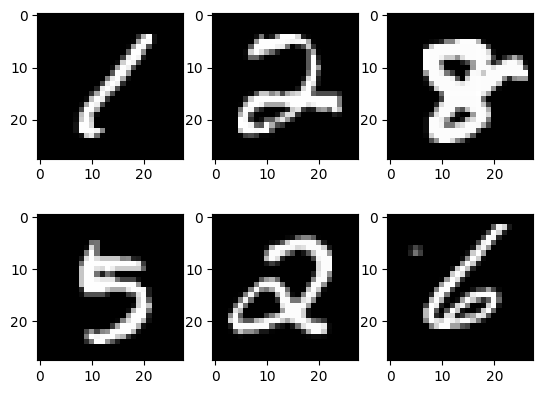

In [ ]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Experiments with MNIST: $β$-Variational Autoencoder

### Experiments 1 : VAE with $\beta$ =0.02 with n_layer=1

- We evaluate the performance of both the autoencoder and the variational autoencoder by systematically varying the latent space dimensionality (Dz) across different values, specifically {2, 16, 32, 64}. Additionally, for this assessment, we set the number of layers (n_layer) to be equal to 1, considering likelihoods modeled as Bernoulli.

## Test 1: $β$-VAE: BCE

### Experiment 3.1 : VAE with 1 layer

- Model: VAE of 1 layer, D_x=784, D_z=2, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_3_1 = 'VAE'
model_config_3_1 = {'D_x': 784, 'n_layers': 1, 'D_z': 2, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_3_1, fold_results_3_1 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_3_1),
                                                model_config=model_config_3_1,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=10,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:367.258974, Training Recons Loss: 333.641971, Training KLD Loss: 3.361700
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.07472441868579134, 'L1 Loss': 0.1975334679826777, 'BCE': 0.30791620498007916}, Validation VAE Loss: {'MSE': 274.92150083501286, 'L1 Loss': 275.415666296127, 'BCE': 275.1039824790143}, Validation Recons Loss: {'MSE': 241.22382500831117, 'L1 Loss': 241.7179875475295, 'BCE': 241.40630470438205}, Validation KLD Loss: {'MSE': 3.369767688690348, 'L1 Loss': 3.369767688690348, 'BCE': 3.369767688690348}
Train Fold/Epoch: 1/2, Training Loss:258.128609, Training Recons Loss: 226.729870, Training KLD Loss: 3.139874
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.06811230336415007, 'L1 Loss': 0.17036156974574354, 'BCE': 0.27851642224382844}, Validation VAE Loss: {'MSE': 245.33

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=10/experience_1_4/'
# Create the directory
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_3_1.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_3_1.pkl')

In [ ]:
# Save models_3_1
with open(models_file_path, 'wb') as f:
    pickle.dump(models_3_1, f)

# Save fold_results_3_1
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_3_1, f)


## Visualizing reconstructions for all fold

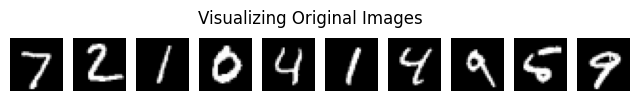

Visualizing reconstructions for fold 1


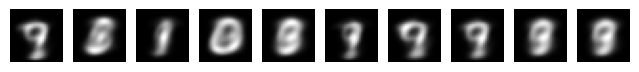

Visualizing reconstructions for fold 2


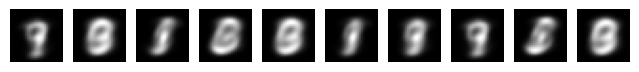

Visualizing reconstructions for fold 3


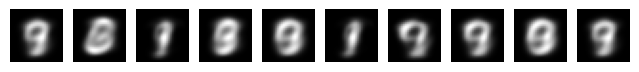

Visualizing reconstructions for fold 4


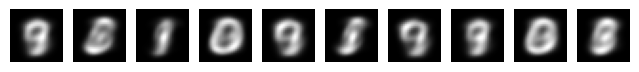

Visualizing reconstructions for fold 5


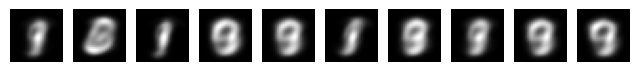

Visualizing reconstructions for fold 6


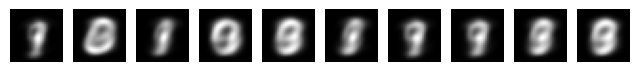

Visualizing reconstructions for fold 7


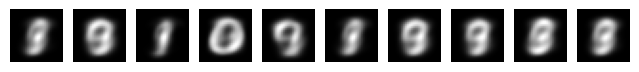

Visualizing reconstructions for fold 8


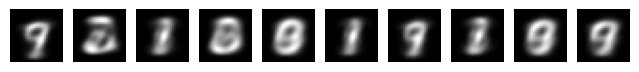

Visualizing reconstructions for fold 9


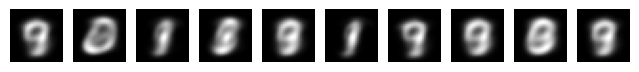

Visualizing reconstructions for fold 10


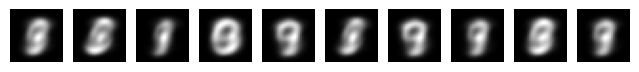

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'models_3_1.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_3_1 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_3_1):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

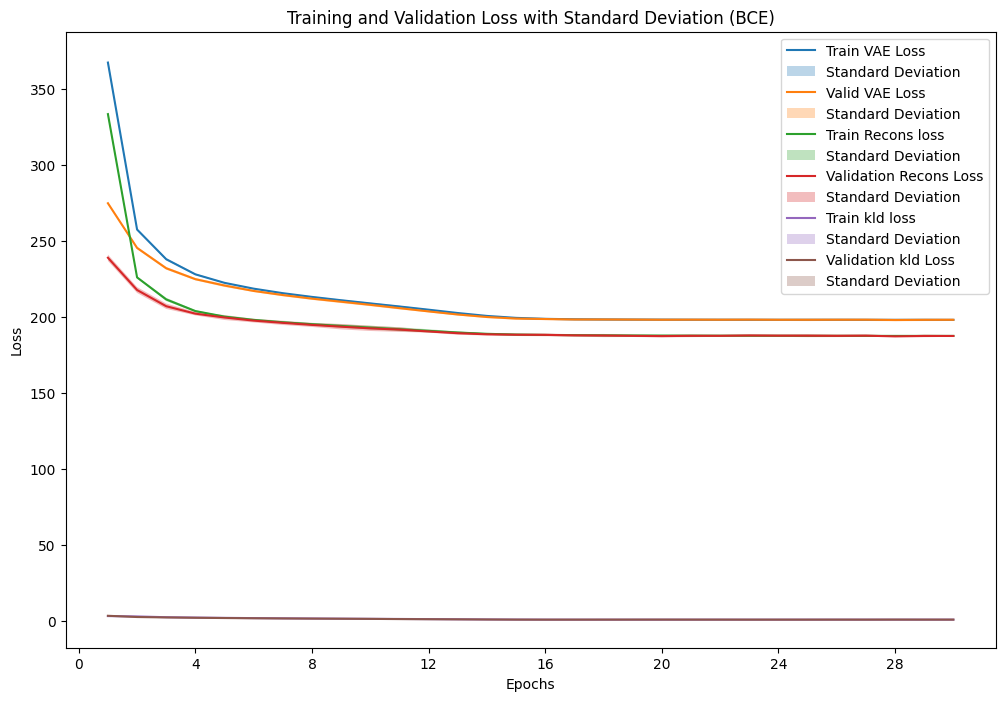

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_3_1.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_3_1 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_3_1_1 = VAE_plot_results(fold_results_3_1, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_3_1_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_3_1_1['epochs'])
    VAE_plot_mean_std(result_data_3_1_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_3_1_1['epochs'])
    VAE_plot_mean_std(result_data_3_1_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_3_1_1['epochs'])
    VAE_plot_mean_std(result_data_3_1_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_3_1_1['epochs'])
    VAE_plot_mean_std(result_data_3_1_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_3_1_1['epochs'])
    VAE_plot_mean_std(result_data_3_1_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_3_1_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_3_1_1['valid_metrics'],
    result_data_3_1_1['test_metrics'],
    result_data_3_1_1['valid_result'],
    result_data_3_1_1['test_result'],
    result_data_3_1_1['recons_valid_result'],
    result_data_3_1_1['recons_test_result'],
    result_data_3_1_1['kld_valid_result'],
    result_data_3_1_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.239396           0.238776           198.319965     197.893418              187.686821        187.686821             1.063314       1.069335
Standard Deviation                 0.000718           0.000397             0.764825       0.105025                0.562764          0.562764             0.032260       0.027137

Detailed Evaluation Table:


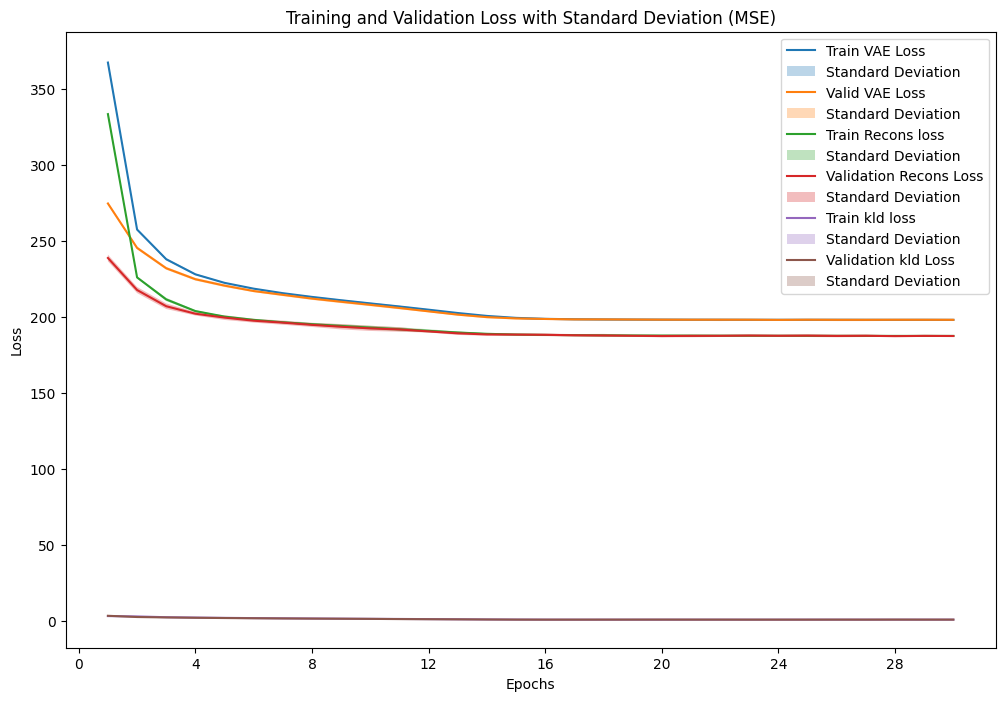

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_3_1.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_3_1 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_3_1_2 = VAE_plot_results(fold_results_3_1, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_3_1_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_3_1_2['epochs'])
    VAE_plot_mean_std(result_data_3_1_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_3_1_2['epochs'])
    VAE_plot_mean_std(result_data_3_1_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_3_1_2['epochs'])
    VAE_plot_mean_std(result_data_3_1_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_3_1_2['epochs'])
    VAE_plot_mean_std(result_data_3_1_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_3_1_2['epochs'])
    VAE_plot_mean_std(result_data_3_1_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_3_1_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_3_1_2['valid_metrics'],
    result_data_3_1_2['test_metrics'],
    result_data_3_1_2['valid_result'],
    result_data_3_1_2['test_result'],
    result_data_3_1_2['recons_valid_result'],
    result_data_3_1_2['recons_test_result'],
    result_data_3_1_2['kld_valid_result'],
    result_data_3_1_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                  0.05992           0.059919           198.251029     197.887829              187.617886        187.617886             1.063314       1.069335
Standard Deviation                  0.00020           0.000137             0.818242       0.088452                0.594875          0.594875             0.032260       0.027137

Detailed Evaluation Table:


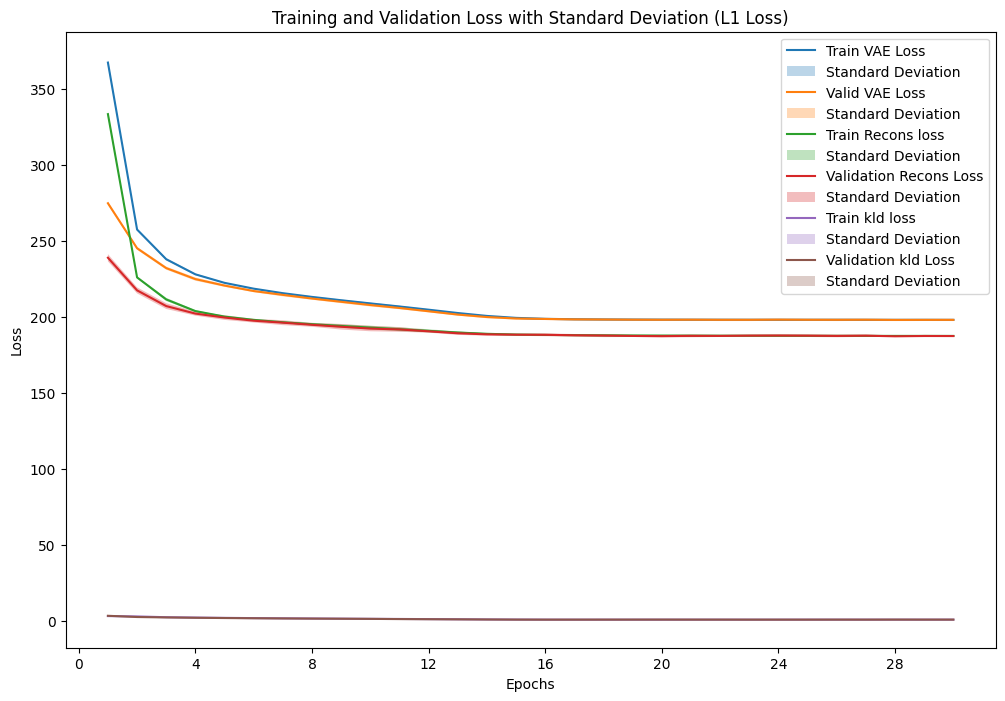

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_3_1.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_3_1 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_3_1_3 = VAE_plot_results(fold_results_3_1, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_3_1_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_3_1_3['epochs'])
    VAE_plot_mean_std(result_data_3_1_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_3_1_3['epochs'])
    VAE_plot_mean_std(result_data_3_1_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_3_1_3['epochs'])
    VAE_plot_mean_std(result_data_3_1_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_3_1_3['epochs'])
    VAE_plot_mean_std(result_data_3_1_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_3_1_3['epochs'])
    VAE_plot_mean_std(result_data_3_1_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_3_1_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_3_1_3['valid_metrics'],
    result_data_3_1_3['test_metrics'],
    result_data_3_1_3['valid_result'],
    result_data_3_1_3['test_result'],
    result_data_3_1_3['recons_valid_result'],
    result_data_3_1_3['recons_test_result'],
    result_data_3_1_3['kld_valid_result'],
    result_data_3_1_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.134885           0.135016           198.209864     197.904786              187.576721        187.576721             1.063314       1.069335
Standard Deviation                 0.000620           0.000261             0.827243       0.080660                0.623256          0.623256             0.032260       0.027137

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_3_1 = sum(p.numel() for p in models_3_1[0].parameters())
print(f"Number of parameters in the model: {total_params_3_1}")

Number of parameters in the model: 5492


### Latent Space Visualization

<ipython-input-10-14e9441719e3>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))


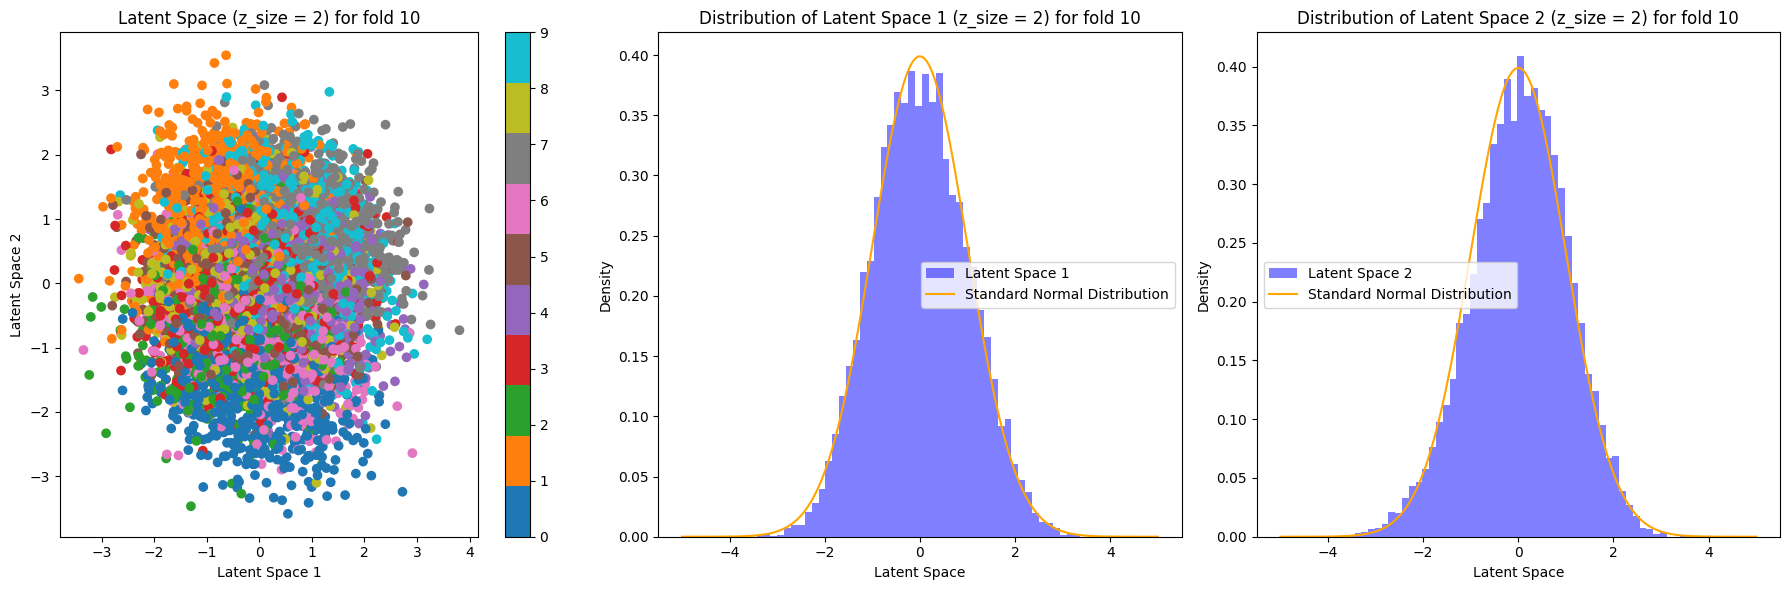

In [ ]:
latent_space_VAE_model(models_3_1[9], test_loader, device, number_fold=10)

### Sample new data using the decoder.

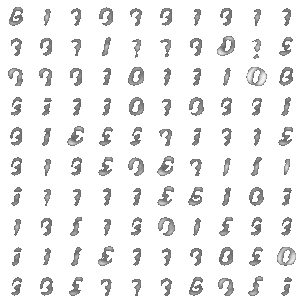

In [ ]:
sample(models_3_1[9],D_z=2)

### Examine the influence of different values of the latent vector z on the results.


We can look at how different values in the latent vector z influence the results.

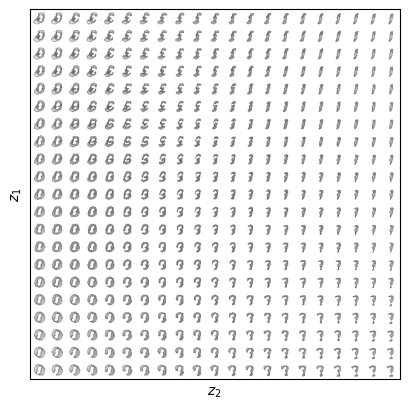

In [ ]:
VAE_visualize_latent_space(models_3_1[9], device)

### Experiment 3.2 : VAE with $\beta$ =0.02 with n_layer=2

- Model: VAE of 1 layer, D_x=784, D_z=16, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_6_2 = 'VAE'
model_config_6_2 = {'D_x': 784, 'n_layers': 1, 'D_z': 16, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_6_2, fold_results_6_2 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_6_2),
                                                model_config=model_config_6_2,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=10,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:310.713664, Training Recons Loss: 266.466046, Training KLD Loss: 4.424762
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.06814811002225318, 'L1 Loss': 0.16961587775260845, 'BCE': 0.2777996434176222}, Validation VAE Loss: {'MSE': 254.56547254197142, 'L1 Loss': 254.62405444206075, 'BCE': 254.40509033203125}, Validation Recons Loss: {'MSE': 217.95530229933718, 'L1 Loss': 218.01388452408162, 'BCE': 217.79492057637967}, Validation KLD Loss: {'MSE': 3.6610169638978673, 'L1 Loss': 3.6610169638978673, 'BCE': 3.6610169638978673}
Train Fold/Epoch: 1/2, Training Loss:245.615907, Training Recons Loss: 206.884674, Training KLD Loss: 3.873123
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.0602980874320294, 'L1 Loss': 0.1432488074010991, 'BCE': 0.24888693255946992}, Validation VAE Loss: {'MSE': 2

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=10/experience_1_4/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_6_2.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_6_2.pkl')

In [ ]:
# Save models_3_2
with open(models_file_path, 'wb') as f:
    pickle.dump(models_6_2, f)

# Save fold_results_3_2
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_6_2, f)


## Visualizing reconstructions for all fold

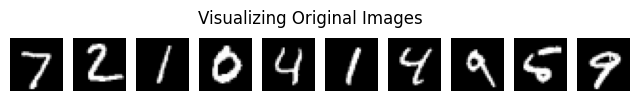

Visualizing reconstructions for fold 1


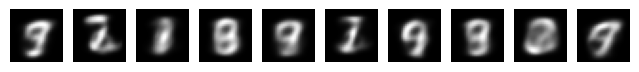

Visualizing reconstructions for fold 2


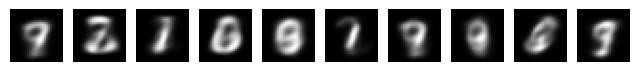

Visualizing reconstructions for fold 3


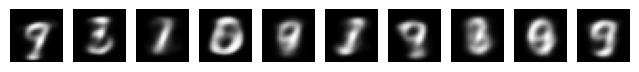

Visualizing reconstructions for fold 4


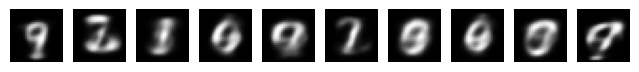

Visualizing reconstructions for fold 5


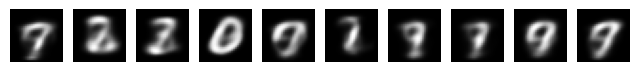

Visualizing reconstructions for fold 6


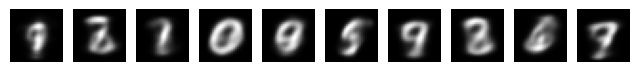

Visualizing reconstructions for fold 7


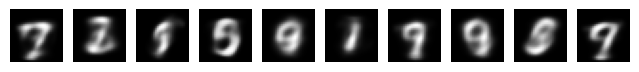

Visualizing reconstructions for fold 8


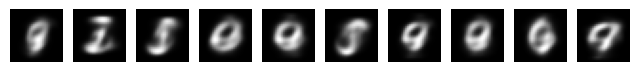

Visualizing reconstructions for fold 9


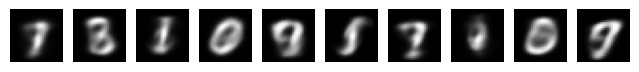

Visualizing reconstructions for fold 10


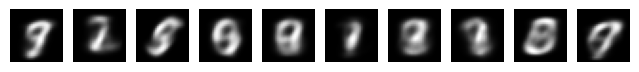

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'models_6_2.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_6_2 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_6_2):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

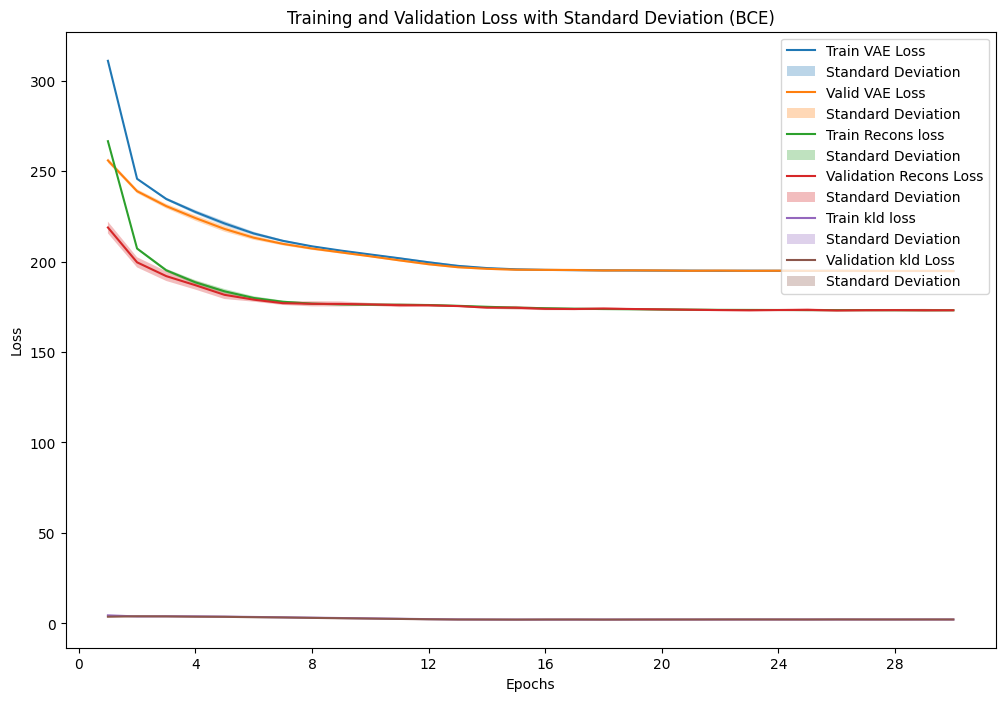

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_2.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_2 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_6_2_1 = VAE_plot_results(fold_results_6_2, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_2_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_2_1['epochs'])
    VAE_plot_mean_std(result_data_6_2_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_2_1['epochs'])
    VAE_plot_mean_std(result_data_6_2_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_2_1['epochs'])
    VAE_plot_mean_std(result_data_6_2_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_2_1['epochs'])
    VAE_plot_mean_std(result_data_6_2_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_2_1['epochs'])
    VAE_plot_mean_std(result_data_6_2_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_2_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_2_1['valid_metrics'],
    result_data_6_2_1['test_metrics'],
    result_data_6_2_1['valid_result'],
    result_data_6_2_1['test_result'],
    result_data_6_2_1['recons_valid_result'],
    result_data_6_2_1['recons_test_result'],
    result_data_6_2_1['kld_valid_result'],
    result_data_6_2_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.220910           0.219931           194.876074     194.280558              173.193650        173.193650             2.168242       2.185502
Standard Deviation                 0.000841           0.000467             0.879267       0.192624                0.659128          0.659128             0.038895       0.032584

Detailed Evaluation Table:


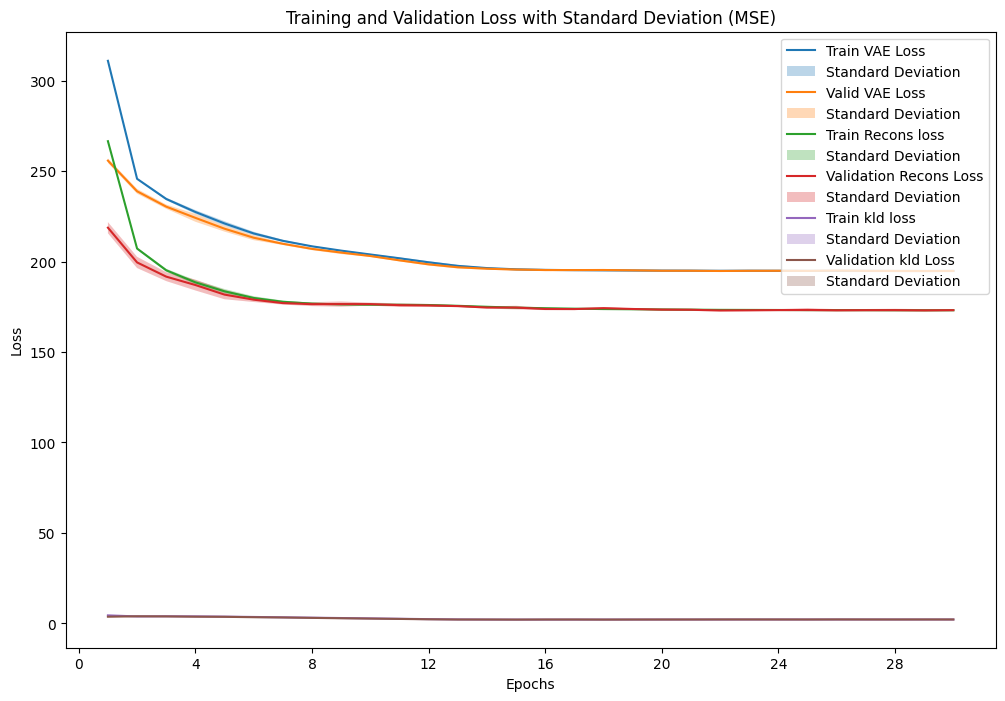

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_2.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_2 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_6_2_2 = VAE_plot_results(fold_results_6_2, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_2_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_2_2['epochs'])
    VAE_plot_mean_std(result_data_6_2_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_2_2['epochs'])
    VAE_plot_mean_std(result_data_6_2_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_2_2['epochs'])
    VAE_plot_mean_std(result_data_6_2_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_2_2['epochs'])
    VAE_plot_mean_std(result_data_6_2_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_2_2['epochs'])
    VAE_plot_mean_std(result_data_6_2_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_2_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_2_2['valid_metrics'],
    result_data_6_2_2['test_metrics'],
    result_data_6_2_2['valid_result'],
    result_data_6_2_2['test_result'],
    result_data_6_2_2['recons_valid_result'],
    result_data_6_2_2['recons_test_result'],
    result_data_6_2_2['kld_valid_result'],
    result_data_6_2_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.053513           0.053362           194.889668     194.383078              173.207244        173.207244             2.168242       2.185502
Standard Deviation                 0.000226           0.000163             0.721573       0.211294                0.534579          0.534579             0.038895       0.032584

Detailed Evaluation Table:


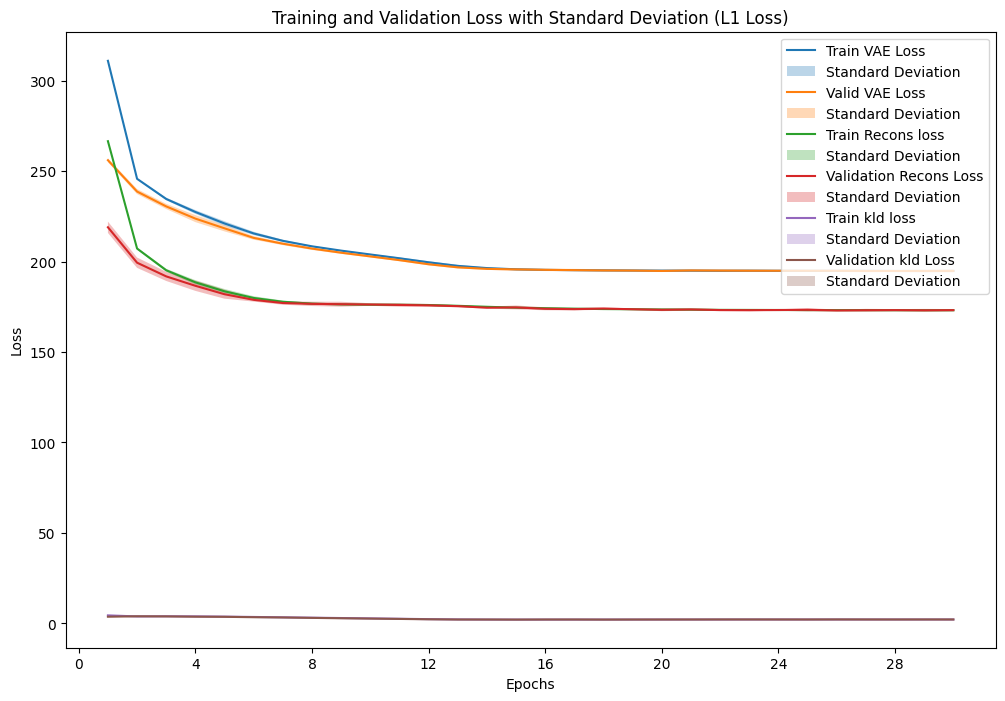

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_2.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_2 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_6_2_3 = VAE_plot_results(fold_results_6_2, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_2_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_2_3['epochs'])
    VAE_plot_mean_std(result_data_6_2_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_2_3['epochs'])
    VAE_plot_mean_std(result_data_6_2_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_2_3['epochs'])
    VAE_plot_mean_std(result_data_6_2_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_2_3['epochs'])
    VAE_plot_mean_std(result_data_6_2_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_2_3['epochs'])
    VAE_plot_mean_std(result_data_6_2_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_2_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_2_3['valid_metrics'],
    result_data_6_2_3['test_metrics'],
    result_data_6_2_3['valid_result'],
    result_data_6_2_3['test_result'],
    result_data_6_2_3['recons_valid_result'],
    result_data_6_2_3['recons_test_result'],
    result_data_6_2_3['kld_valid_result'],
    result_data_6_2_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.122259           0.122068           194.953407     194.368449              173.270983        173.270983             2.168242       2.185502
Standard Deviation                 0.000601           0.000422             0.758728       0.191261                0.615996          0.615996             0.038895       0.032584

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_6_2 = sum(p.numel() for p in models_6_2[0].parameters())
print(f"Number of parameters in the model: {total_params_6_2}")

Number of parameters in the model: 38448


### Sample new data using the decoder.

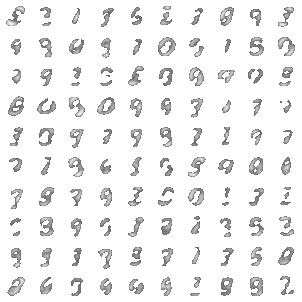

In [ ]:
sample(models_6_2[9],D_z=16)

### Experiment 3.3 : VAE with $\beta$ =0.02 with n_layer=1

- Model: VAE of 1 layer, D_x=784, D_z=32, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_6_3 = 'VAE'
model_config_6_3 = {'D_x': 784, 'n_layers': 1, 'D_z': 32, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_6_3, fold_results_6_3 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_6_3),
                                                model_config=model_config_6_3,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=10,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:300.883533, Training Recons Loss: 255.817185, Training KLD Loss: 4.506635
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.06517983374601984, 'L1 Loss': 0.15447861542727084, 'BCE': 0.2642161904814396}, Validation VAE Loss: {'MSE': 253.88590110616482, 'L1 Loss': 254.24120671698387, 'BCE': 253.25157766139253}, Validation Recons Loss: {'MSE': 207.77981697244846, 'L1 Loss': 208.13512339490526, 'BCE': 207.14549304069357}, Validation KLD Loss: {'MSE': 4.610608405255257, 'L1 Loss': 4.610608405255257, 'BCE': 4.610608405255257}
Train Fold/Epoch: 1/2, Training Loss:246.653236, Training Recons Loss: 206.608316, Training KLD Loss: 4.004492
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.061641339688224994, 'L1 Loss': 0.14487022383415954, 'BCE': 0.2534909845983728}, Validation VAE Loss: {'MSE': 24

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=10/experience_1_4/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_6_3.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_6_3.pkl')

In [ ]:
# Save models_3_3
with open(models_file_path, 'wb') as f:
    pickle.dump(models_6_3, f)

# Save fold_results_3_3
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_6_3, f)


## Visualizing reconstructions for all fold

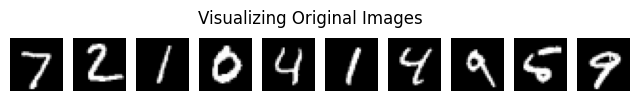

Visualizing reconstructions for fold 1


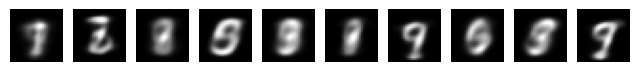

Visualizing reconstructions for fold 2


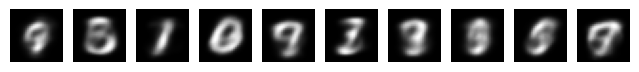

Visualizing reconstructions for fold 3


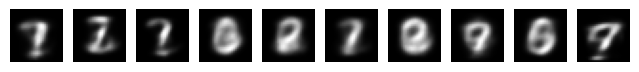

Visualizing reconstructions for fold 4


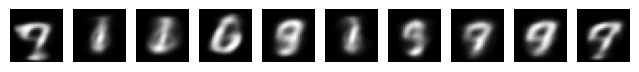

Visualizing reconstructions for fold 5


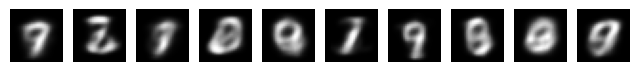

Visualizing reconstructions for fold 6


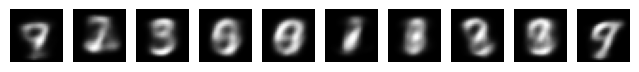

Visualizing reconstructions for fold 7


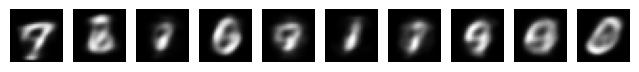

Visualizing reconstructions for fold 8


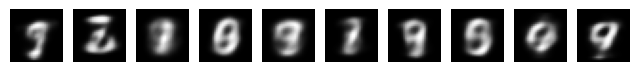

Visualizing reconstructions for fold 9


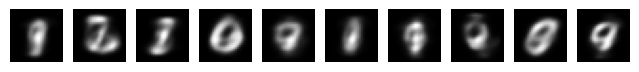

Visualizing reconstructions for fold 10


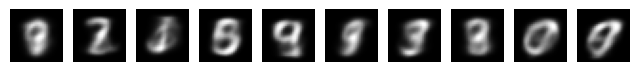

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'models_6_3.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_6_3 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_6_3):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

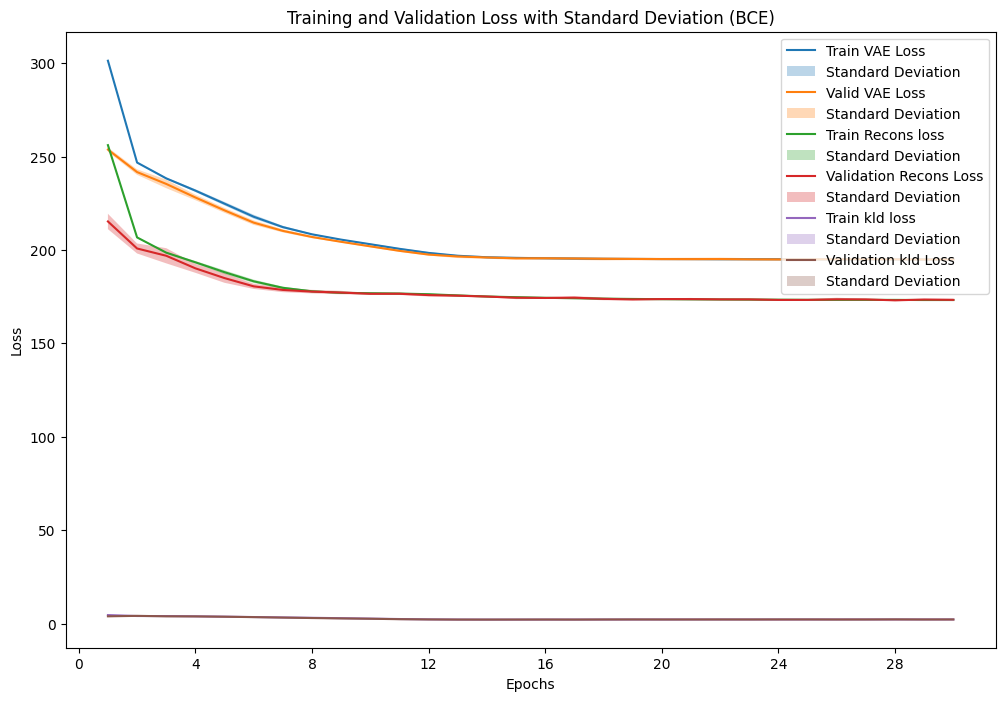

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_3.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_3 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_6_3_1 = VAE_plot_results(fold_results_6_3, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_3_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_3_1['epochs'])
    VAE_plot_mean_std(result_data_6_3_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_3_1['epochs'])
    VAE_plot_mean_std(result_data_6_3_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_3_1['epochs'])
    VAE_plot_mean_std(result_data_6_3_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_3_1['epochs'])
    VAE_plot_mean_std(result_data_6_3_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_3_1['epochs'])
    VAE_plot_mean_std(result_data_6_3_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_3_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_3_1['valid_metrics'],
    result_data_6_3_1['test_metrics'],
    result_data_6_3_1['valid_result'],
    result_data_6_3_1['test_result'],
    result_data_6_3_1['recons_valid_result'],
    result_data_6_3_1['recons_test_result'],
    result_data_6_3_1['kld_valid_result'],
    result_data_6_3_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.221134           0.220114           195.025283     194.417348              173.368814        173.368814             2.165647       2.184823
Standard Deviation                 0.000807           0.000646             0.740850       0.183704                0.632491          0.632491             0.058473       0.046816

Detailed Evaluation Table:


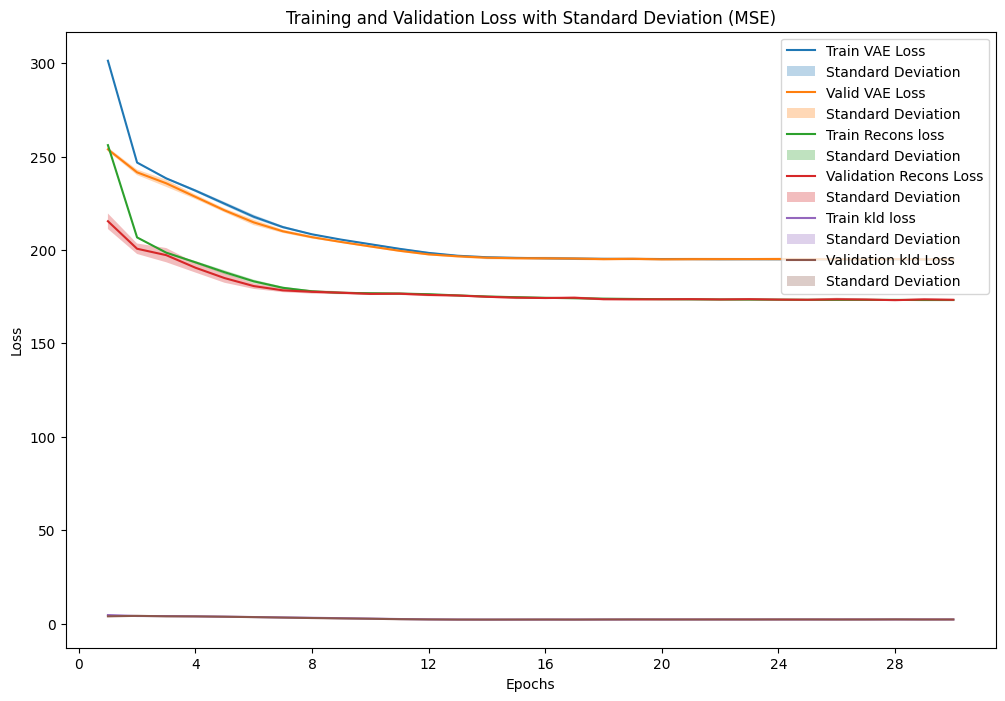

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_3.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_3 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_6_3_2 = VAE_plot_results(fold_results_6_3, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_3_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_3_2['epochs'])
    VAE_plot_mean_std(result_data_6_3_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_3_2['epochs'])
    VAE_plot_mean_std(result_data_6_3_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_3_2['epochs'])
    VAE_plot_mean_std(result_data_6_3_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_3_2['epochs'])
    VAE_plot_mean_std(result_data_6_3_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_3_2['epochs'])
    VAE_plot_mean_std(result_data_6_3_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_3_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_3_2['valid_metrics'],
    result_data_6_3_2['test_metrics'],
    result_data_6_3_2['valid_result'],
    result_data_6_3_2['test_result'],
    result_data_6_3_2['recons_valid_result'],
    result_data_6_3_2['recons_test_result'],
    result_data_6_3_2['kld_valid_result'],
    result_data_6_3_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.053550           0.053412           194.921024     194.461769              173.264554        173.264554             2.165647       2.184823
Standard Deviation                 0.000177           0.000241             0.801345       0.117656                0.520640          0.520640             0.058473       0.046816

Detailed Evaluation Table:


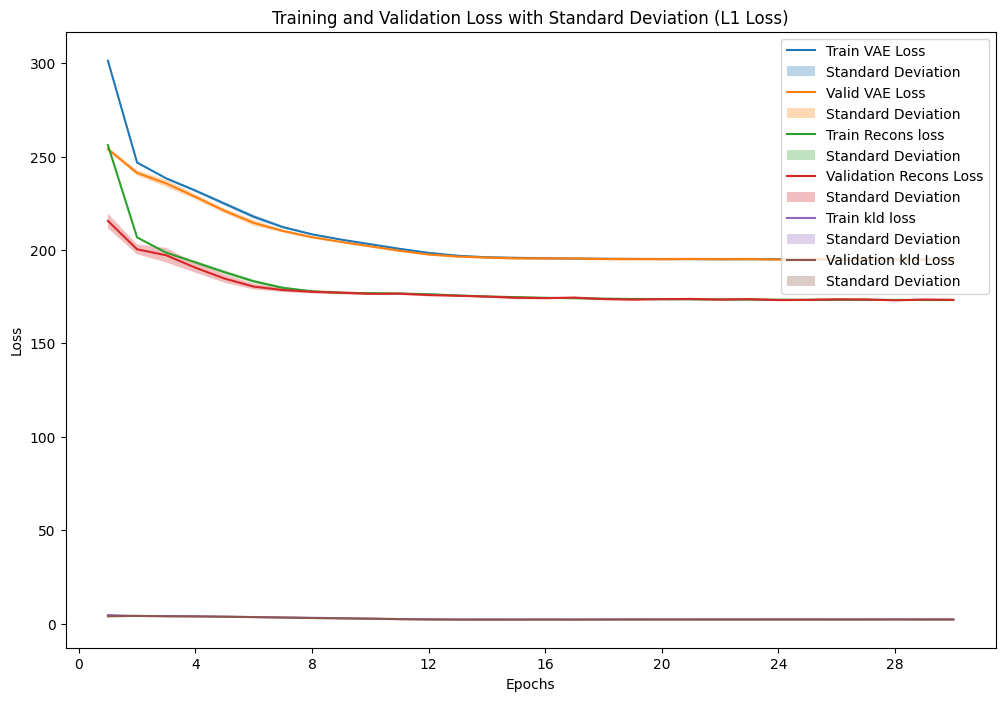

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_3.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_3 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_6_3_3 = VAE_plot_results(fold_results_6_3, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_3_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_3_3['epochs'])
    VAE_plot_mean_std(result_data_6_3_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_3_3['epochs'])
    VAE_plot_mean_std(result_data_6_3_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_3_3['epochs'])
    VAE_plot_mean_std(result_data_6_3_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_3_3['epochs'])
    VAE_plot_mean_std(result_data_6_3_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_3_3['epochs'])
    VAE_plot_mean_std(result_data_6_3_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_3_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_3_3['valid_metrics'],
    result_data_6_3_3['test_metrics'],
    result_data_6_3_3['valid_result'],
    result_data_6_3_3['test_result'],
    result_data_6_3_3['recons_valid_result'],
    result_data_6_3_3['recons_test_result'],
    result_data_6_3_3['kld_valid_result'],
    result_data_6_3_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.121909           0.121914           194.881921     194.448701              173.225451        173.225451             2.165647       2.184823
Standard Deviation                 0.000429           0.000273             0.737681       0.186231                0.547206          0.547206             0.058473       0.046816

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_6_3 = sum(p.numel() for p in models_6_3[0].parameters())
print(f"Number of parameters in the model: {total_params_6_3}")

Number of parameters in the model: 76112


### Sample new data using the decoder.

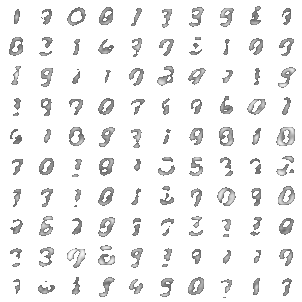

In [ ]:
sample(models_6_3[9],D_z=32)

### Experiment 3.4 : VAE with $\beta$ =0.02 with n_layer=1

- Model: VAE of 1 layer, D_x=784, D_z=64, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_6_4 = 'VAE'
model_config_6_4 = {'D_x': 784, 'n_layers': 1, 'D_z': 64, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_6_4, fold_results_6_4 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_6_4),
                                                model_config=model_config_6_4,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=10,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:294.094507, Training Recons Loss: 248.124083, Training KLD Loss: 4.597042
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.06576912346831028, 'L1 Loss': 0.1568944695148062, 'BCE': 0.2667027951238003}, Validation VAE Loss: {'MSE': 253.05650719175947, 'L1 Loss': 253.6149839036008, 'BCE': 252.844364085096}, Validation Recons Loss: {'MSE': 209.30713393840384, 'L1 Loss': 209.86561081257273, 'BCE': 209.09499066941282}, Validation KLD Loss: {'MSE': 4.374937311131903, 'L1 Loss': 4.374937311131903, 'BCE': 4.374937311131903}
Train Fold/Epoch: 1/2, Training Loss:249.185826, Training Recons Loss: 207.252832, Training KLD Loss: 4.193299
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.0646322010520925, 'L1 Loss': 0.1532352736338656, 'BCE': 0.2613721616724704}, Validation VAE Loss: {'MSE': 244.11943

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=10/experience_1_4/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_6_4.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_6_4.pkl')

In [ ]:
# Save models_3_4
with open(models_file_path, 'wb') as f:
    pickle.dump(models_6_4, f)

# Save fold_results_3_4
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_6_4, f)


## Visualizing reconstructions for all fold

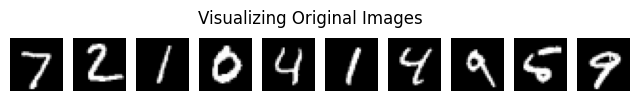

Visualizing reconstructions for fold 1


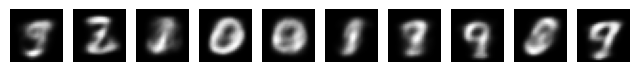

Visualizing reconstructions for fold 2


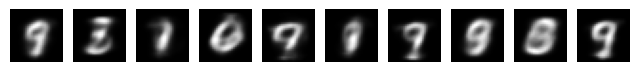

Visualizing reconstructions for fold 3


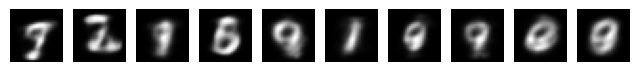

Visualizing reconstructions for fold 4


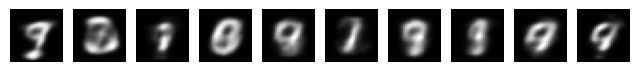

Visualizing reconstructions for fold 5


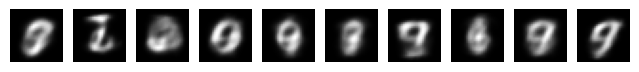

Visualizing reconstructions for fold 6


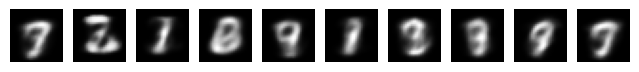

Visualizing reconstructions for fold 7


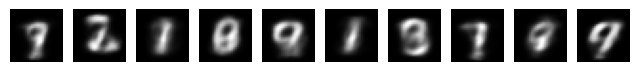

Visualizing reconstructions for fold 8


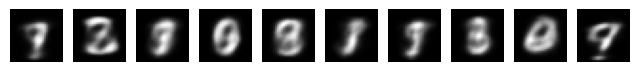

Visualizing reconstructions for fold 9


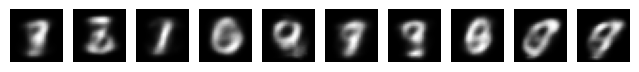

Visualizing reconstructions for fold 10


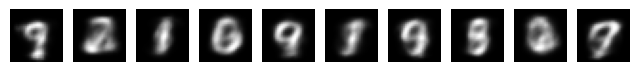

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'models_6_4.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_6_4 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_6_4):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

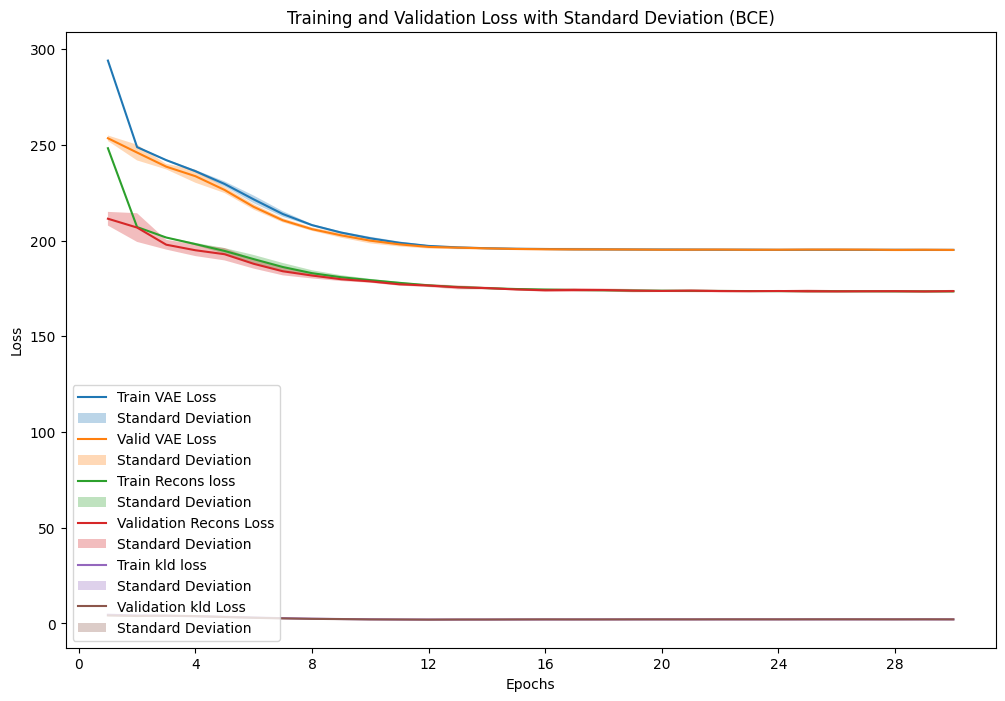

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_4.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_4 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_6_4_1 = VAE_plot_results(fold_results_6_4, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_4_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_4_1['epochs'])
    VAE_plot_mean_std(result_data_6_4_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_4_1['epochs'])
    VAE_plot_mean_std(result_data_6_4_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_4_1['epochs'])
    VAE_plot_mean_std(result_data_6_4_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_4_1['epochs'])
    VAE_plot_mean_std(result_data_6_4_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_4_1['epochs'])
    VAE_plot_mean_std(result_data_6_4_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_4_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_4_1['valid_metrics'],
    result_data_6_4_1['test_metrics'],
    result_data_6_4_1['valid_result'],
    result_data_6_4_1['test_result'],
    result_data_6_4_1['recons_valid_result'],
    result_data_6_4_1['recons_test_result'],
    result_data_6_4_1['kld_valid_result'],
    result_data_6_4_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.221600           0.220615           195.241163     194.635004              173.734534        173.734534             2.150663       2.167313
Standard Deviation                 0.000828           0.000765             0.590012       0.107986                0.649331          0.649331             0.072759       0.063890

Detailed Evaluation Table:


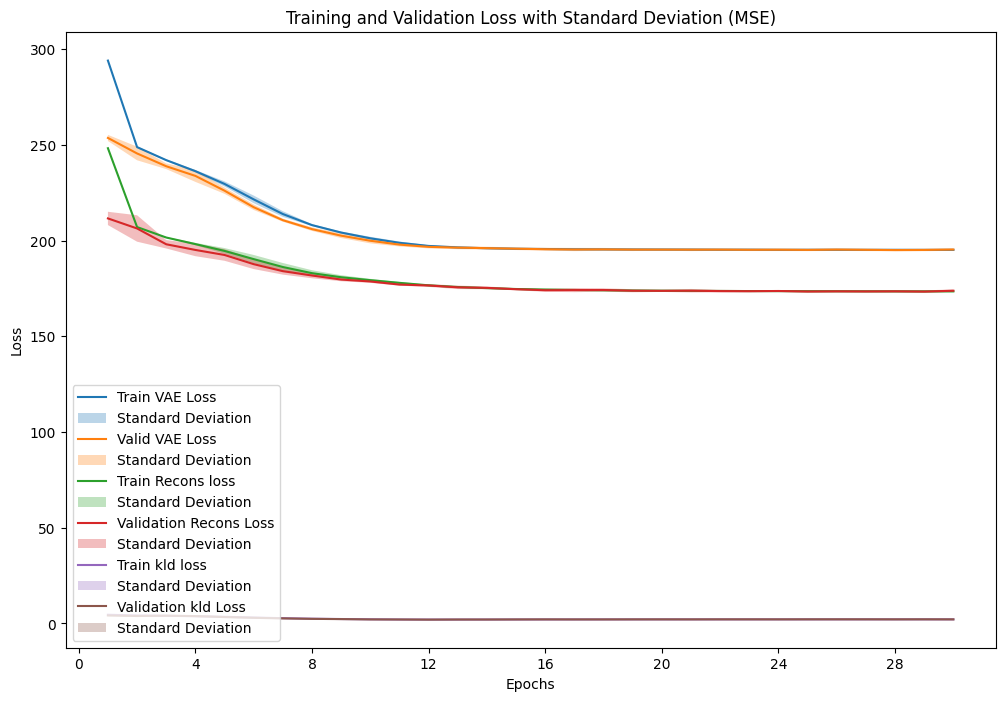

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_4.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_4 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_6_4_2 = VAE_plot_results(fold_results_6_4, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_4_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_4_2['epochs'])
    VAE_plot_mean_std(result_data_6_4_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_4_2['epochs'])
    VAE_plot_mean_std(result_data_6_4_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_4_2['epochs'])
    VAE_plot_mean_std(result_data_6_4_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_4_2['epochs'])
    VAE_plot_mean_std(result_data_6_4_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_4_2['epochs'])
    VAE_plot_mean_std(result_data_6_4_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_4_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_4_2['valid_metrics'],
    result_data_6_4_2['test_metrics'],
    result_data_6_4_2['valid_result'],
    result_data_6_4_2['test_result'],
    result_data_6_4_2['recons_valid_result'],
    result_data_6_4_2['recons_test_result'],
    result_data_6_4_2['kld_valid_result'],
    result_data_6_4_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.053796           0.053579           195.297899     194.638199              173.791270        173.791270             2.150663       2.167313
Standard Deviation                 0.000232           0.000309             0.702794       0.145642                0.592366          0.592366             0.072759       0.063890

Detailed Evaluation Table:


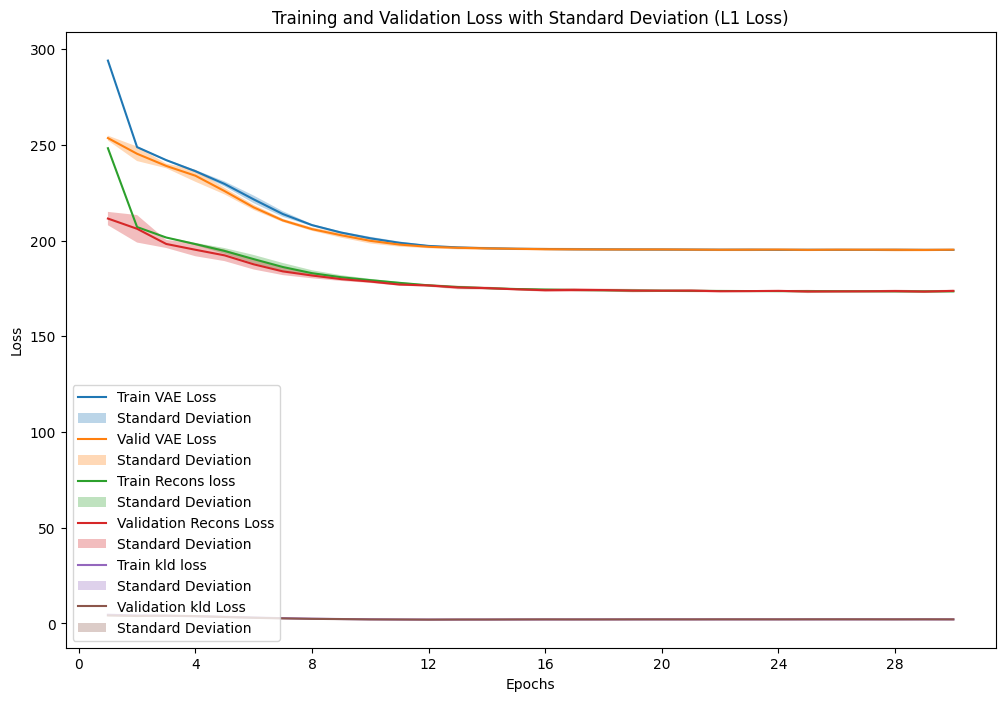

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_4.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_4 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_6_4_3 = VAE_plot_results(fold_results_6_4, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_4_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_4_3['epochs'])
    VAE_plot_mean_std(result_data_6_4_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_4_3['epochs'])
    VAE_plot_mean_std(result_data_6_4_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_4_3['epochs'])
    VAE_plot_mean_std(result_data_6_4_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_4_3['epochs'])
    VAE_plot_mean_std(result_data_6_4_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_4_3['epochs'])
    VAE_plot_mean_std(result_data_6_4_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_4_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_4_3['valid_metrics'],
    result_data_6_4_3['test_metrics'],
    result_data_6_4_3['valid_result'],
    result_data_6_4_3['test_result'],
    result_data_6_4_3['recons_valid_result'],
    result_data_6_4_3['recons_test_result'],
    result_data_6_4_3['kld_valid_result'],
    result_data_6_4_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.121969           0.121876           195.181129     194.659352              173.674501        173.674501             2.150663       2.167313
Standard Deviation                 0.000538           0.000631             0.726813       0.221159                0.614681          0.614681             0.072759       0.063890

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_6_4 = sum(p.numel() for p in models_6_4[0].parameters())
print(f"Number of parameters in the model: {total_params_6_4}")

Number of parameters in the model: 151440


### Sample new data using the decoder.

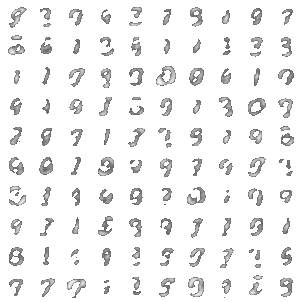

In [ ]:
sample(models_6_4[9],D_z=64)

## Test 2 VAE: BCE

### Experiments 2 : VAE with $\beta$ =0.02 with n_layer =2

- We evaluate the performance of both the autoencoder and the variational autoencoder by systematically varying the latent space dimensionality (Dz) across different values, specifically {2, 16, 32}. Additionally, for this assessment, we set the number of layers (n_layer) to be equal to 1, considering likelihoods modeled as Bernoulli.

### Experiment 3.1 : VAE with 2 layer

- Model: VAE of 2 layer, D_x=784, D_z=2, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_6_6 = 'VAE'
model_config_6_6 = {'D_x': 784, 'n_layers': 2, 'D_z': 2, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_6_6, fold_results_6_6 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_6_6),
                                                model_config=model_config_6_6,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=10,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:202.021164, Training Recons Loss: 188.468588, Training KLD Loss: 1.355258
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.05524751456811073, 'L1 Loss': 0.12632390587253772, 'BCE': 0.2260928309344231}, Validation VAE Loss: {'MSE': 193.39611946268283, 'L1 Loss': 193.1829019100108, 'BCE': 193.05835366756358}, Validation Recons Loss: {'MSE': 177.59454475565158, 'L1 Loss': 177.38132752763465, 'BCE': 177.25677977217003}, Validation KLD Loss: {'MSE': 1.5801574131275744, 'L1 Loss': 1.5801574131275744, 'BCE': 1.5801574131275744}
Train Fold/Epoch: 1/2, Training Loss:192.313686, Training Recons Loss: 173.951273, Training KLD Loss: 1.836241
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.052743082866072655, 'L1 Loss': 0.12163633718452554, 'BCE': 0.218707744745498}, Validation VAE Loss: {'MSE': 1

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=10/experience_1_4/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_6_6.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_6_6.pkl')

In [ ]:
# Save models_3_6
with open(models_file_path, 'wb') as f:
    pickle.dump(models_6_6, f)

# Save fold_results_3_6
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_6_6, f)


## Visualizing reconstructions for all fold

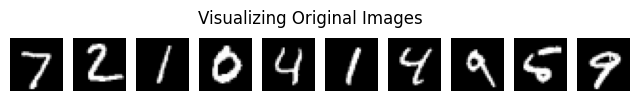

Visualizing reconstructions for fold 1


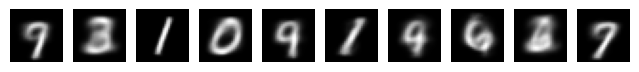

Visualizing reconstructions for fold 2


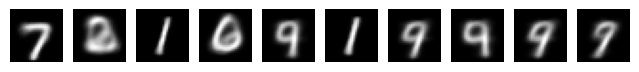

Visualizing reconstructions for fold 3


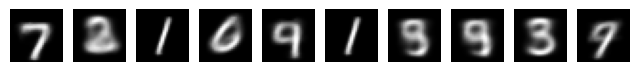

Visualizing reconstructions for fold 4


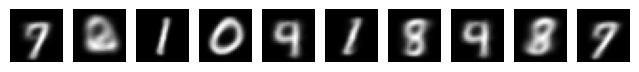

Visualizing reconstructions for fold 5


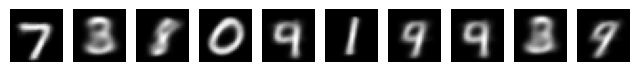

Visualizing reconstructions for fold 6


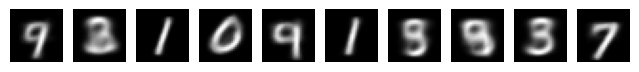

Visualizing reconstructions for fold 7


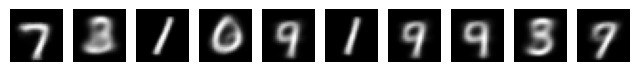

Visualizing reconstructions for fold 8


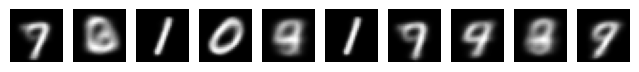

Visualizing reconstructions for fold 9


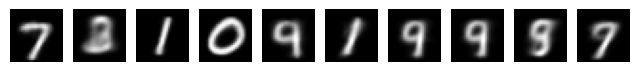

Visualizing reconstructions for fold 10


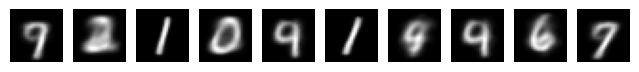

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'models_6_6.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_6_6 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_6_6):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

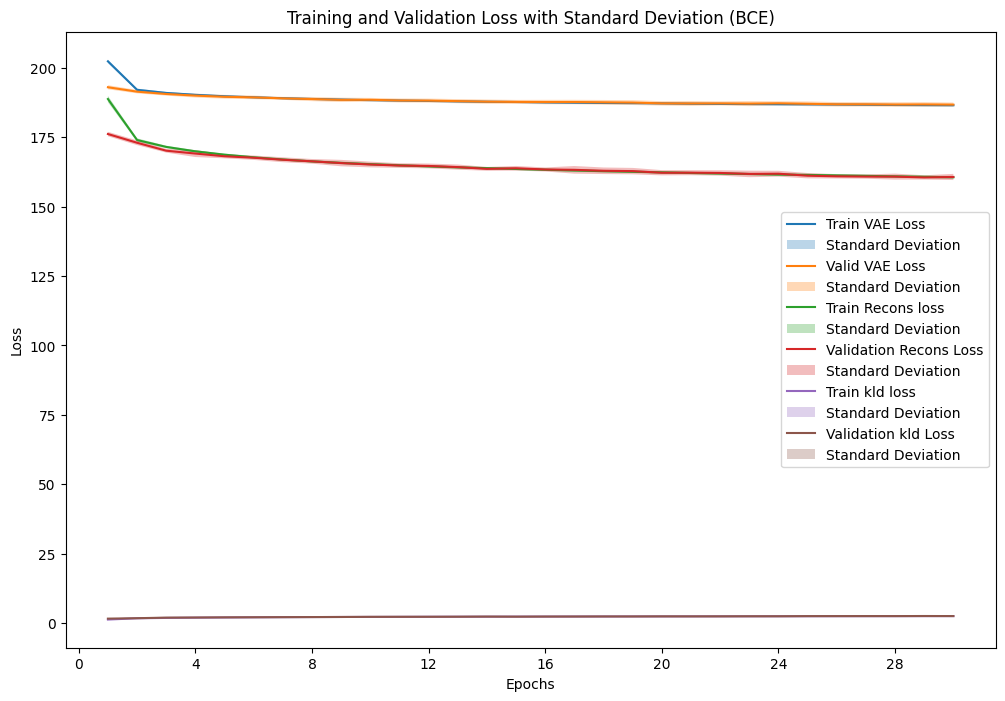

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_6.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_6 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_6_6_1 = VAE_plot_results(fold_results_6_6, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_6_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_6_1['epochs'])
    VAE_plot_mean_std(result_data_6_6_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_6_1['epochs'])
    VAE_plot_mean_std(result_data_6_6_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_6_1['epochs'])
    VAE_plot_mean_std(result_data_6_6_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_6_1['epochs'])
    VAE_plot_mean_std(result_data_6_6_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_6_1['epochs'])
    VAE_plot_mean_std(result_data_6_6_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_6_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_6_1['valid_metrics'],
    result_data_6_6_1['test_metrics'],
    result_data_6_6_1['valid_result'],
    result_data_6_6_1['test_result'],
    result_data_6_6_1['recons_valid_result'],
    result_data_6_6_1['recons_test_result'],
    result_data_6_6_1['kld_valid_result'],
    result_data_6_6_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.204970           0.204603           186.727399     186.359805               160.69673         160.69673             2.603067       2.595134
Standard Deviation                 0.001384           0.001184             0.700045       0.339671                 1.08523           1.08523             0.072401       0.077065

Detailed Evaluation Table:


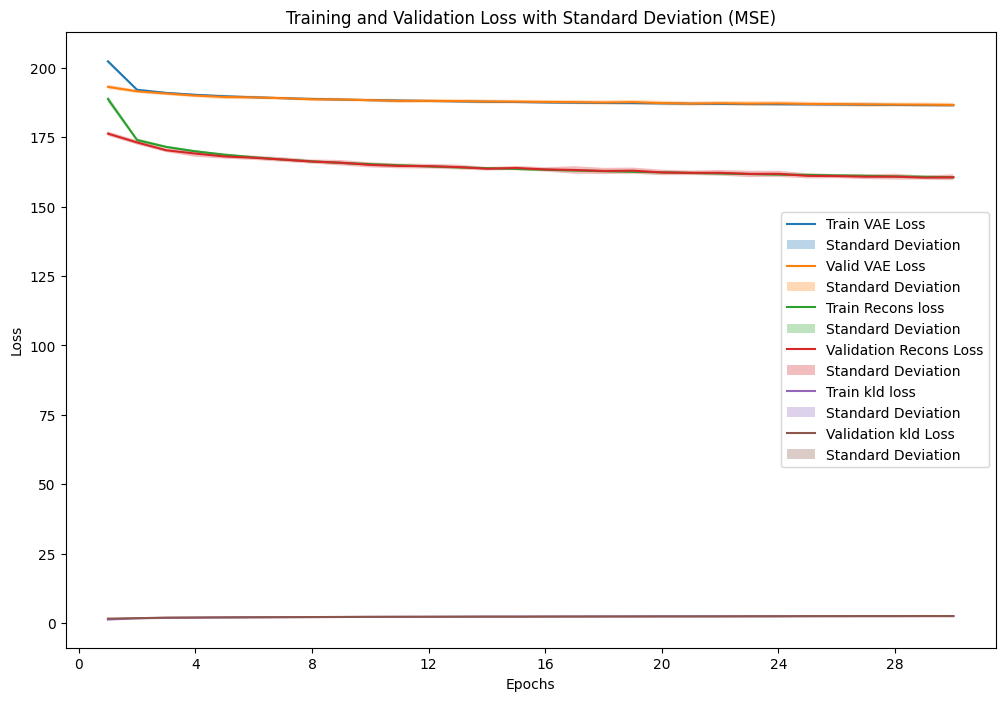

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_6.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_6 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_6_6_2 = VAE_plot_results(fold_results_6_6, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_6_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_6_2['epochs'])
    VAE_plot_mean_std(result_data_6_6_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_6_2['epochs'])
    VAE_plot_mean_std(result_data_6_6_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_6_2['epochs'])
    VAE_plot_mean_std(result_data_6_6_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_6_2['epochs'])
    VAE_plot_mean_std(result_data_6_6_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_6_2['epochs'])
    VAE_plot_mean_std(result_data_6_6_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_6_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_6_2['valid_metrics'],
    result_data_6_6_2['test_metrics'],
    result_data_6_6_2['valid_result'],
    result_data_6_6_2['test_result'],
    result_data_6_6_2['recons_valid_result'],
    result_data_6_6_2['recons_test_result'],
    result_data_6_6_2['kld_valid_result'],
    result_data_6_6_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.048418           0.048443           186.730657     186.393268              160.699988        160.699988             2.603067       2.595134
Standard Deviation                 0.000525           0.000470             0.741978       0.342157                1.122758          1.122758             0.072401       0.077065

Detailed Evaluation Table:


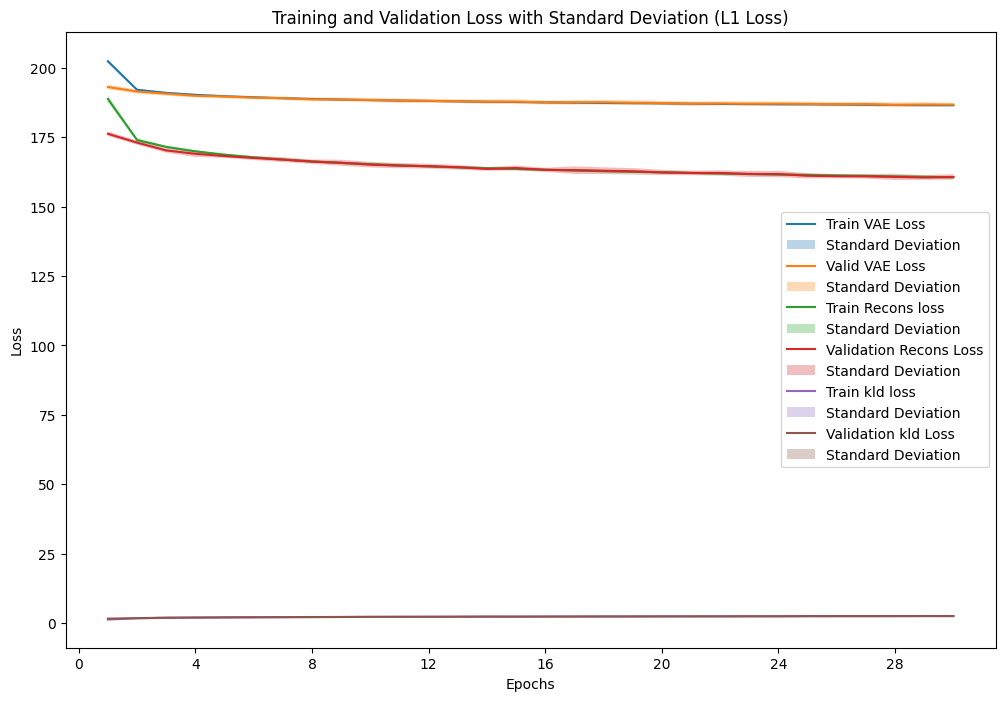

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_6.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_6 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_6_6_3 = VAE_plot_results(fold_results_6_6, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_6_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_6_3['epochs'])
    VAE_plot_mean_std(result_data_6_6_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_6_3['epochs'])
    VAE_plot_mean_std(result_data_6_6_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_6_3['epochs'])
    VAE_plot_mean_std(result_data_6_6_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_6_3['epochs'])
    VAE_plot_mean_std(result_data_6_6_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_6_3['epochs'])
    VAE_plot_mean_std(result_data_6_6_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_6_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_6_3['valid_metrics'],
    result_data_6_6_3['test_metrics'],
    result_data_6_6_3['valid_result'],
    result_data_6_6_3['test_result'],
    result_data_6_6_3['recons_valid_result'],
    result_data_6_6_3['recons_test_result'],
    result_data_6_6_3['kld_valid_result'],
    result_data_6_6_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.111766           0.112022           186.580433     186.411972              160.549764        160.549764             2.603067       2.595134
Standard Deviation                 0.000848           0.000851             0.736176       0.336929                1.080092          1.080092             0.072401       0.077065

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_6_6 = sum(p.numel() for p in models_6_6[0].parameters())
print(f"Number of parameters in the model: {total_params_6_6}")

Number of parameters in the model: 620156


<ipython-input-9-14e9441719e3>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))


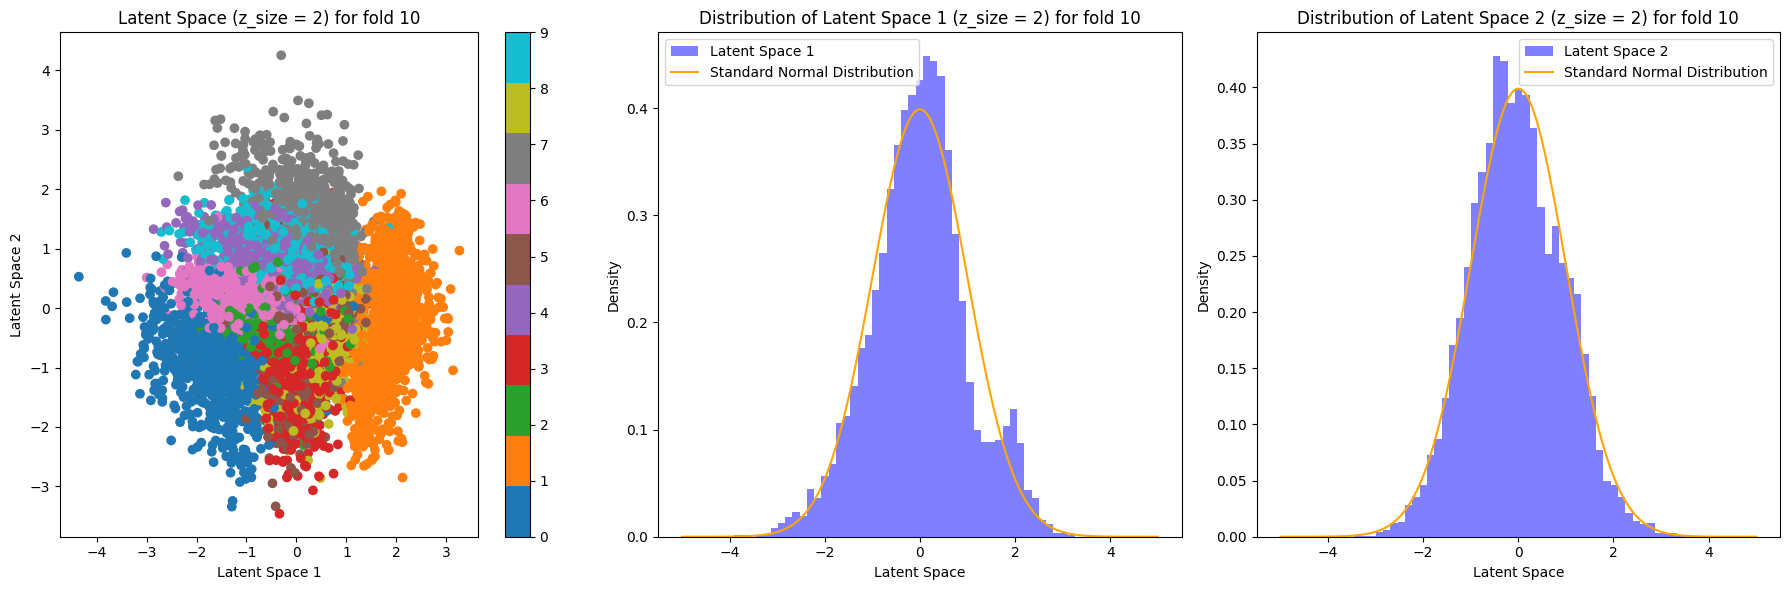

In [ ]:
latent_space_VAE_model(models_6_6[9], test_loader, device, number_fold=10)

### Sample new data using the decoder.

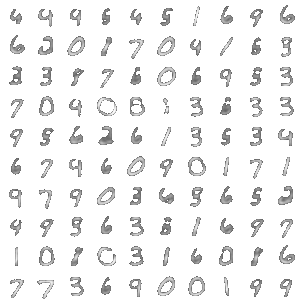

In [ ]:
sample(models_6_6[9],D_z=2)

### Examine the influence of different values of the latent vector z on the results.


We can look at how different values in the latent vector z influence the results.

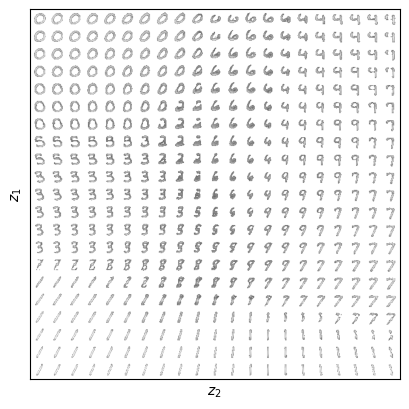

In [ ]:
VAE_visualize_latent_space(models_6_6[9], device)

### Experiment 3.2 : VAE with $\beta$ =0.02 with n_layer=2

- Model: VAE of 2 layer, D_x=784, D_z=16, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_6_7 = 'VAE'
model_config_6_7 = {'D_x': 784, 'n_layers': 2, 'D_z': 16, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_6_7, fold_results_6_7 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_6_7),
                                                model_config=model_config_6_7,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=10,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:204.962222, Training Recons Loss: 190.467762, Training KLD Loss: 1.449446
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.05264111774715972, 'L1 Loss': 0.12030071543252215, 'BCE': 0.2186640833920621}, Validation VAE Loss: {'MSE': 193.18175263100483, 'L1 Loss': 192.78725936564993, 'BCE': 193.2565005687957}, Validation Recons Loss: {'MSE': 171.35789376116813, 'L1 Loss': 170.96340065814078, 'BCE': 171.43264153663148}, Validation KLD Loss: {'MSE': 2.182385984887468, 'L1 Loss': 2.182385984887468, 'BCE': 2.182385984887468}
Train Fold/Epoch: 1/2, Training Loss:191.220663, Training Recons Loss: 165.125554, Training KLD Loss: 2.609511
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.048380079421591254, 'L1 Loss': 0.11199280041012358, 'BCE': 0.20596952229104143}, Validation VAE Loss: {'MSE': 18

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=10/experience_1_4/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_6_7.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_6_7.pkl')

In [ ]:
# Save models_3_7
with open(models_file_path, 'wb') as f:
    pickle.dump(models_6_7, f)

# Save fold_results_3_7
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_6_7, f)


## Visualizing reconstructions for all fold

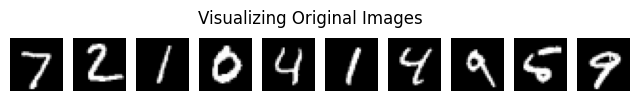

Visualizing reconstructions for fold 1


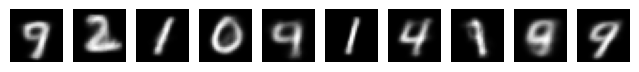

Visualizing reconstructions for fold 2


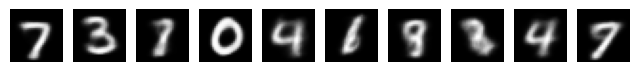

Visualizing reconstructions for fold 3


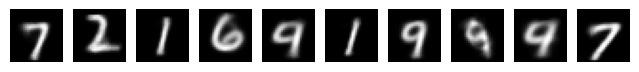

Visualizing reconstructions for fold 4


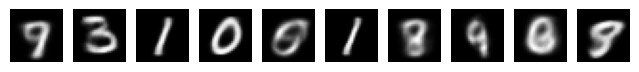

Visualizing reconstructions for fold 5


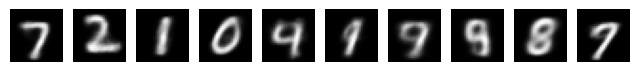

Visualizing reconstructions for fold 6


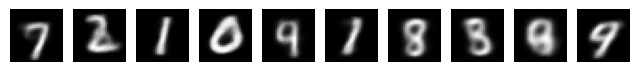

Visualizing reconstructions for fold 7


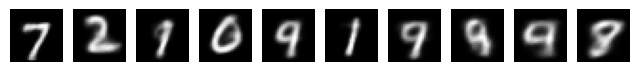

Visualizing reconstructions for fold 8


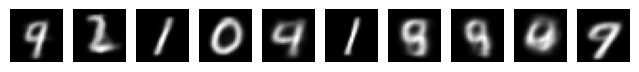

Visualizing reconstructions for fold 9


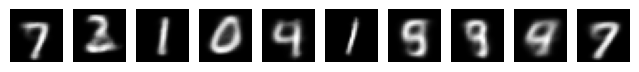

Visualizing reconstructions for fold 10


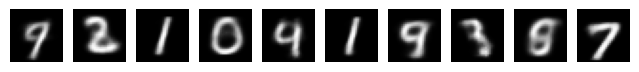

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'models_6_7.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_6_7 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_6_7):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

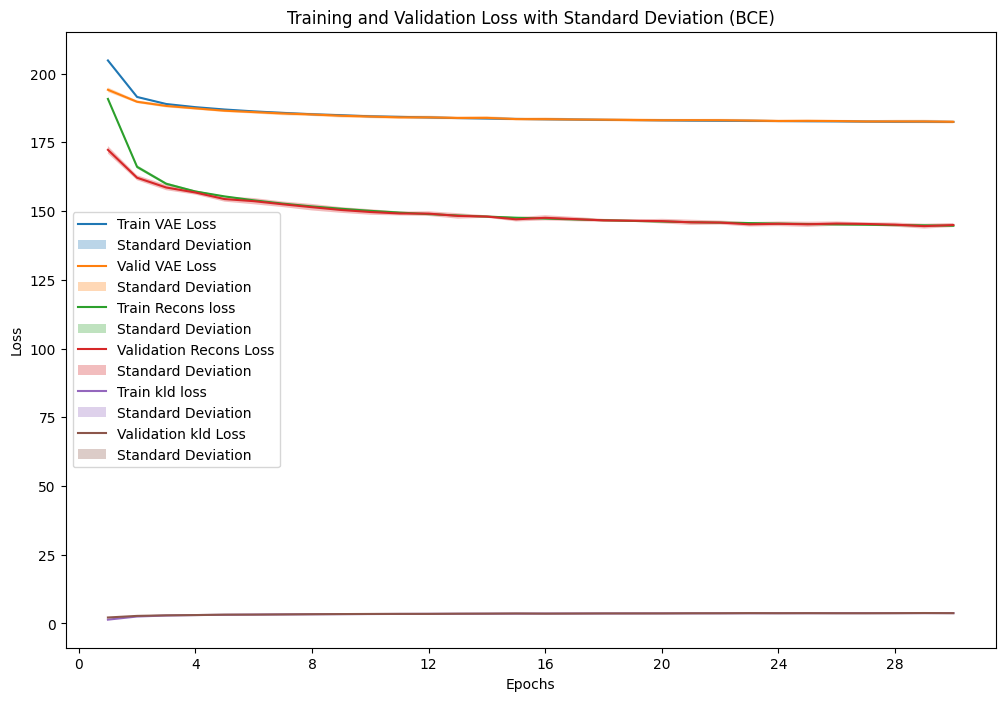

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_7.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_7 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_6_7_1 = VAE_plot_results(fold_results_6_7, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_7_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_7_1['epochs'])
    VAE_plot_mean_std(result_data_6_7_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_7_1['epochs'])
    VAE_plot_mean_std(result_data_6_7_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_7_1['epochs'])
    VAE_plot_mean_std(result_data_6_7_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_7_1['epochs'])
    VAE_plot_mean_std(result_data_6_7_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_7_1['epochs'])
    VAE_plot_mean_std(result_data_6_7_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_7_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_7_1['valid_metrics'],
    result_data_6_7_1['test_metrics'],
    result_data_6_7_1['valid_result'],
    result_data_6_7_1['test_result'],
    result_data_6_7_1['recons_valid_result'],
    result_data_6_7_1['recons_test_result'],
    result_data_6_7_1['kld_valid_result'],
    result_data_6_7_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.185056           0.184375           182.612567     182.114201              145.083813        145.083813             3.752875       3.756452
Standard Deviation                 0.000977           0.000760             0.642538       0.116058                0.765594          0.765594             0.068408       0.061516

Detailed Evaluation Table:


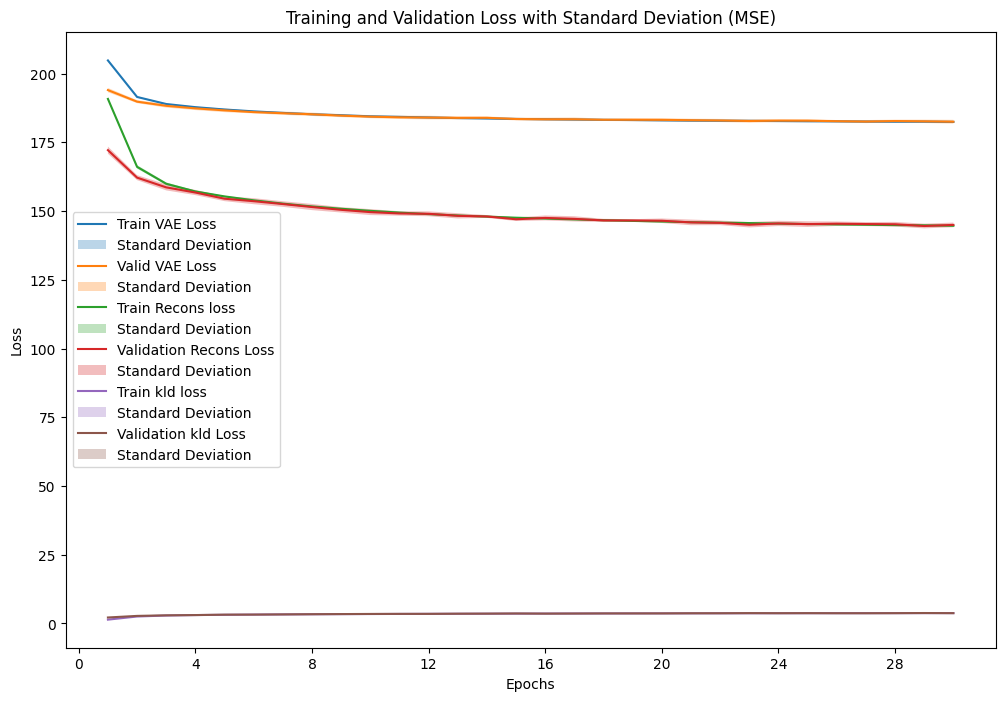

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_7.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_7 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_6_7_2 = VAE_plot_results(fold_results_6_7, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_7_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_7_2['epochs'])
    VAE_plot_mean_std(result_data_6_7_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_7_2['epochs'])
    VAE_plot_mean_std(result_data_6_7_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_7_2['epochs'])
    VAE_plot_mean_std(result_data_6_7_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_7_2['epochs'])
    VAE_plot_mean_std(result_data_6_7_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_7_2['epochs'])
    VAE_plot_mean_std(result_data_6_7_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_7_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_7_2['valid_metrics'],
    result_data_6_7_2['test_metrics'],
    result_data_6_7_2['valid_result'],
    result_data_6_7_2['test_result'],
    result_data_6_7_2['recons_valid_result'],
    result_data_6_7_2['recons_test_result'],
    result_data_6_7_2['kld_valid_result'],
    result_data_6_7_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.041475           0.041312           182.555046     182.052745              145.026292        145.026292             3.752875       3.756452
Standard Deviation                 0.000245           0.000294             0.486554       0.204475                0.652371          0.652371             0.068408       0.061516

Detailed Evaluation Table:


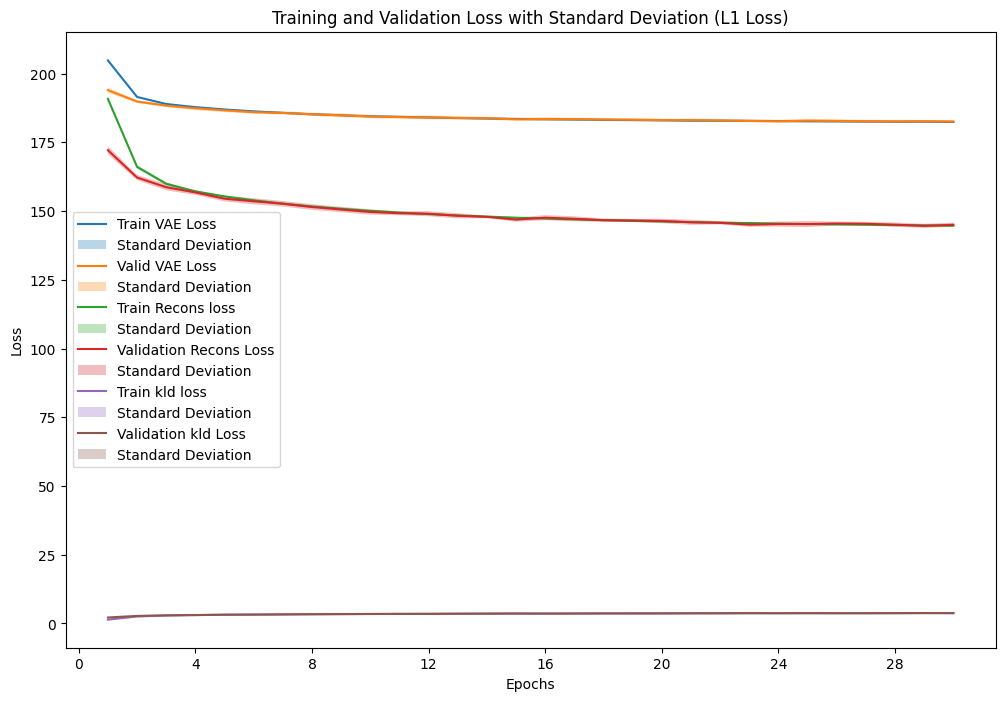

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_7.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_7 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_6_7_3 = VAE_plot_results(fold_results_6_7, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_7_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_7_3['epochs'])
    VAE_plot_mean_std(result_data_6_7_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_7_3['epochs'])
    VAE_plot_mean_std(result_data_6_7_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_7_3['epochs'])
    VAE_plot_mean_std(result_data_6_7_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_7_3['epochs'])
    VAE_plot_mean_std(result_data_6_7_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_7_3['epochs'])
    VAE_plot_mean_std(result_data_6_7_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_7_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_7_3['valid_metrics'],
    result_data_6_7_3['test_metrics'],
    result_data_6_7_3['valid_result'],
    result_data_6_7_3['test_result'],
    result_data_6_7_3['recons_valid_result'],
    result_data_6_7_3['recons_test_result'],
    result_data_6_7_3['kld_valid_result'],
    result_data_6_7_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.097944           0.097849           182.549026     182.020109              145.020273        145.020273             3.752875       3.756452
Standard Deviation                 0.000540           0.000489             0.704099       0.171773                0.891024          0.891024             0.068408       0.061516

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_6_7 = sum(p.numel() for p in models_6_7[0].parameters())
print(f"Number of parameters in the model: {total_params_6_7}")

Number of parameters in the model: 648016


### Sample new data using the decoder.

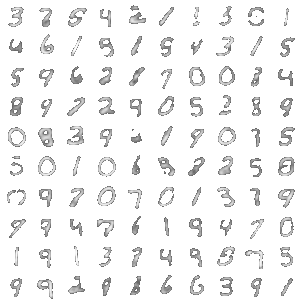

In [ ]:
sample(models_6_7[9],D_z=16)

### Experiment 3.3 : VAE with $\beta$ =0.02 with n_layer=2

- Model: VAE of 2 layer, D_x=784, D_z=32, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_6_8 = 'VAE'
model_config_6_8 = {'D_x': 784, 'n_layers': 2, 'D_z': 32, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_6_8, fold_results_6_8 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_6_8),
                                                model_config=model_config_6_8,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=10,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:206.991134, Training Recons Loss: 196.302211, Training KLD Loss: 1.068892
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.05652855146438517, 'L1 Loss': 0.12882328493163941, 'BCE': 0.23136423591603625}, Validation VAE Loss: {'MSE': 197.48947013692654, 'L1 Loss': 197.79501147980386, 'BCE': 198.4229044812791}, Validation Recons Loss: {'MSE': 180.45612676092918, 'L1 Loss': 180.76166826613405, 'BCE': 181.3895609429542}, Validation KLD Loss: {'MSE': 1.7033343378533707, 'L1 Loss': 1.7033343378533707, 'BCE': 1.7033343378533707}
Train Fold/Epoch: 1/2, Training Loss:194.481104, Training Recons Loss: 173.183277, Training KLD Loss: 2.129783
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.05024255958801888, 'L1 Loss': 0.11568364588187095, 'BCE': 0.21109719479337652}, Validation VAE Loss: {'MSE': 

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=10/experience_1_4/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_6_8.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_6_8.pkl')

In [ ]:
# Save models_3_8
with open(models_file_path, 'wb') as f:
    pickle.dump(models_6_8, f)

# Save fold_results_3_8
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_6_8, f)


## Visualizing reconstructions for all fold

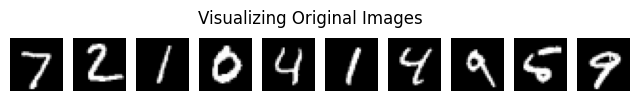

Visualizing reconstructions for fold 1


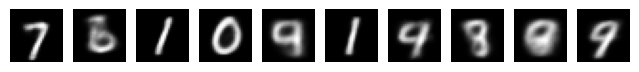

Visualizing reconstructions for fold 2


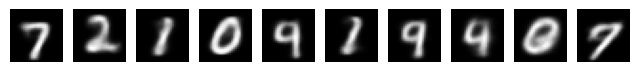

Visualizing reconstructions for fold 3


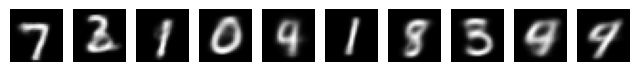

Visualizing reconstructions for fold 4


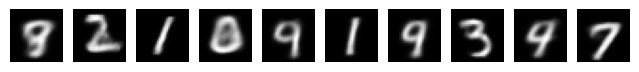

Visualizing reconstructions for fold 5


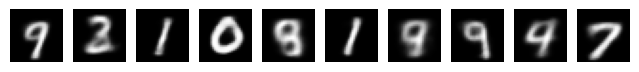

Visualizing reconstructions for fold 6


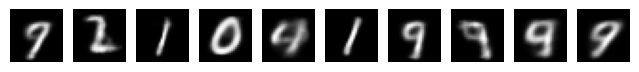

Visualizing reconstructions for fold 7


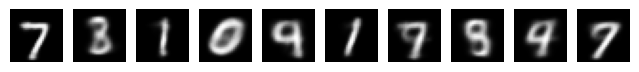

Visualizing reconstructions for fold 8


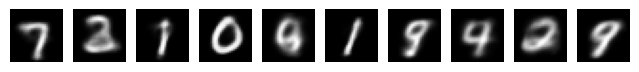

Visualizing reconstructions for fold 9


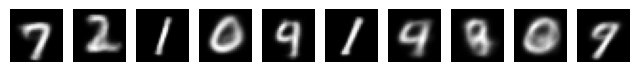

Visualizing reconstructions for fold 10


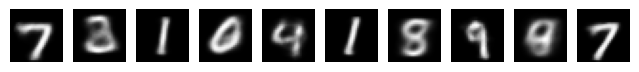

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'models_6_8.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_6_8 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_6_8):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

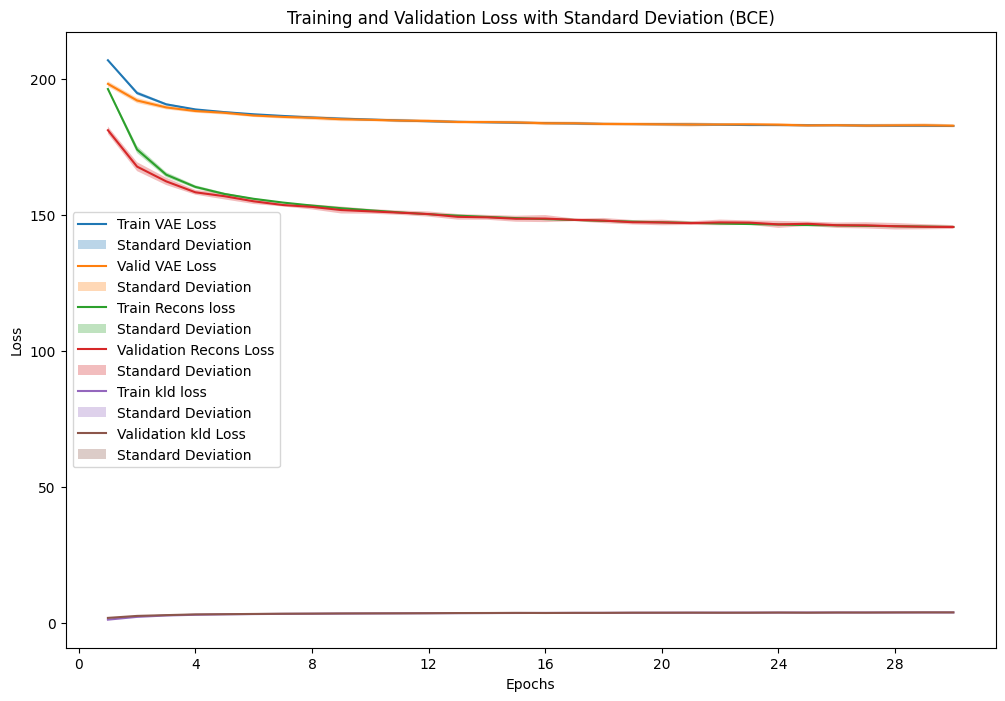

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_8.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_8 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_6_8_1 = VAE_plot_results(fold_results_6_8, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_8_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_8_1['epochs'])
    VAE_plot_mean_std(result_data_6_8_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_8_1['epochs'])
    VAE_plot_mean_std(result_data_6_8_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_8_1['epochs'])
    VAE_plot_mean_std(result_data_6_8_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_8_1['epochs'])
    VAE_plot_mean_std(result_data_6_8_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_8_1['epochs'])
    VAE_plot_mean_std(result_data_6_8_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_8_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_8_1['valid_metrics'],
    result_data_6_8_1['test_metrics'],
    result_data_6_8_1['valid_result'],
    result_data_6_8_1['test_result'],
    result_data_6_8_1['recons_valid_result'],
    result_data_6_8_1['recons_test_result'],
    result_data_6_8_1['kld_valid_result'],
    result_data_6_8_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.185783           0.185067           182.930918     182.381028              145.654161        145.654161             3.727676       3.728872
Standard Deviation                 0.000885           0.000982             0.630463       0.132146                0.694005          0.694005             0.085893       0.078347

Detailed Evaluation Table:


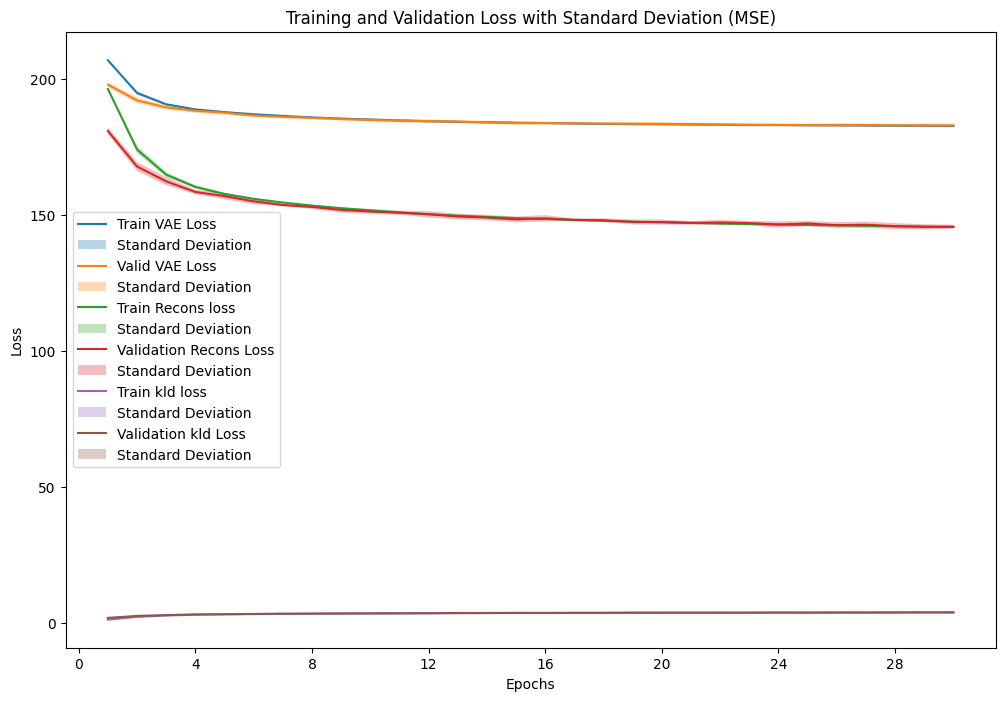

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_8.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_8 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_6_8_2 = VAE_plot_results(fold_results_6_8, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_8_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_8_2['epochs'])
    VAE_plot_mean_std(result_data_6_8_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_8_2['epochs'])
    VAE_plot_mean_std(result_data_6_8_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_8_2['epochs'])
    VAE_plot_mean_std(result_data_6_8_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_8_2['epochs'])
    VAE_plot_mean_std(result_data_6_8_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_8_2['epochs'])
    VAE_plot_mean_std(result_data_6_8_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_8_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_8_2['valid_metrics'],
    result_data_6_8_2['test_metrics'],
    result_data_6_8_2['valid_result'],
    result_data_6_8_2['test_result'],
    result_data_6_8_2['recons_valid_result'],
    result_data_6_8_2['recons_test_result'],
    result_data_6_8_2['kld_valid_result'],
    result_data_6_8_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.041687           0.041579           182.780128     182.333647              145.503370        145.503370             3.727676       3.728872
Standard Deviation                 0.000314           0.000361             0.619298       0.196270                0.667976          0.667976             0.085893       0.078347

Detailed Evaluation Table:


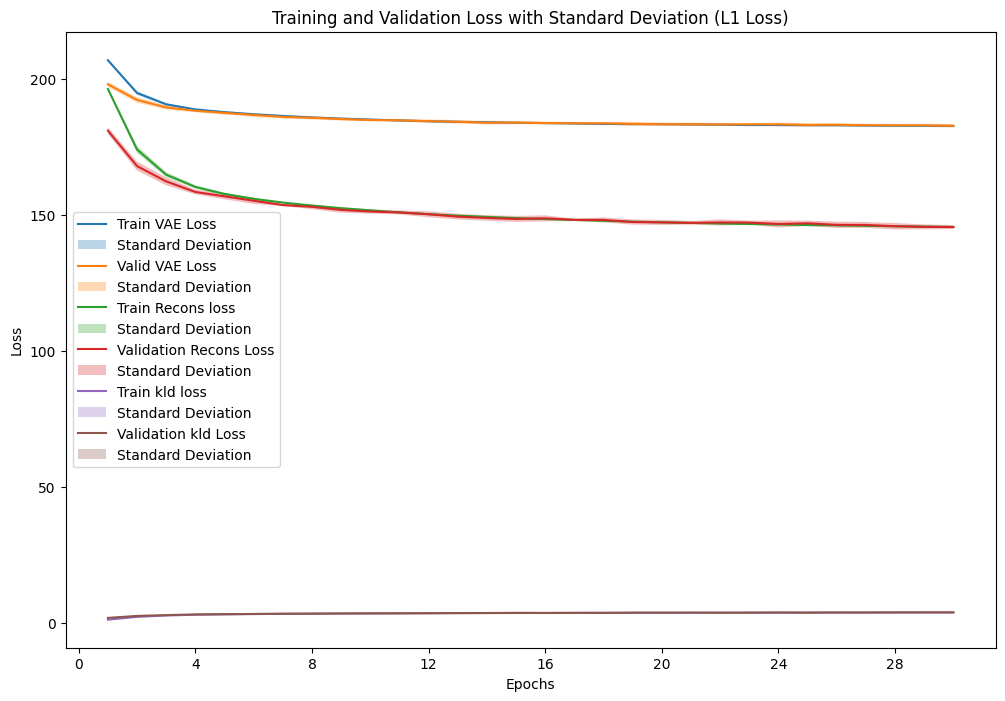

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_8.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_8 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_6_8_3 = VAE_plot_results(fold_results_6_8, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_8_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_8_3['epochs'])
    VAE_plot_mean_std(result_data_6_8_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_8_3['epochs'])
    VAE_plot_mean_std(result_data_6_8_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_8_3['epochs'])
    VAE_plot_mean_std(result_data_6_8_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_8_3['epochs'])
    VAE_plot_mean_std(result_data_6_8_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_8_3['epochs'])
    VAE_plot_mean_std(result_data_6_8_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_8_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_8_3['valid_metrics'],
    result_data_6_8_3['test_metrics'],
    result_data_6_8_3['valid_result'],
    result_data_6_8_3['test_result'],
    result_data_6_8_3['recons_valid_result'],
    result_data_6_8_3['recons_test_result'],
    result_data_6_8_3['kld_valid_result'],
    result_data_6_8_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.098135           0.098089           182.806277     182.392690              145.529520        145.529520             3.727676       3.728872
Standard Deviation                 0.000591           0.000701             0.714543       0.128936                0.702672          0.702672             0.085893       0.078347

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_6_8 = sum(p.numel() for p in models_6_8[0].parameters())
print(f"Number of parameters in the model: {total_params_6_8}")

Number of parameters in the model: 680576


### Sample new data using the decoder.

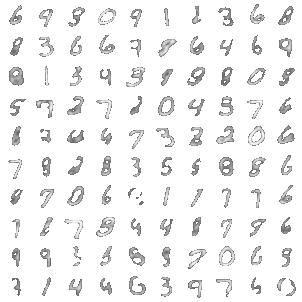

In [ ]:
sample(models_6_8[9],D_z=32)

### Experiment 2.4 : VAE with 2 layer

- Model: VAE of 1 layer, D_x=784, D_z=64, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_6_9 = 'VAE'
model_config_6_9 = {'D_x': 784, 'n_layers': 2, 'D_z': 64, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_6_9, fold_results_6_9 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_6_9),
                                                model_config=model_config_6_9,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=10,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:207.666075, Training Recons Loss: 198.750125, Training KLD Loss: 0.891595
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.058872818035331176, 'L1 Loss': 0.13376217446428665, 'BCE': 0.23654954373202425}, Validation VAE Loss: {'MSE': 199.81646777213888, 'L1 Loss': 200.26167281130526, 'BCE': 199.39794775780211}, Validation Recons Loss: {'MSE': 185.87336260207155, 'L1 Loss': 186.31856731658286, 'BCE': 185.45484210075216}, Validation KLD Loss: {'MSE': 1.3943105073685342, 'L1 Loss': 1.3943105073685342, 'BCE': 1.3943105073685342}
Train Fold/Epoch: 1/2, Training Loss:199.026942, Training Recons Loss: 182.738505, Training KLD Loss: 1.628844
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.056394362465498296, 'L1 Loss': 0.12733626096172534, 'BCE': 0.22984895490585489}, Validation VAE Loss: {'MS

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=10/experience_1_4/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_6_9.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_6_9.pkl')

In [ ]:
# Save models_3_1
with open(models_file_path, 'wb') as f:
    pickle.dump(models_6_9, f)

# Save fold_results_3_1
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_6_9, f)


## Visualizing reconstructions for all fold

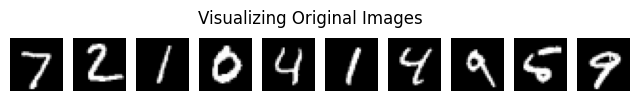

Visualizing reconstructions for fold 1


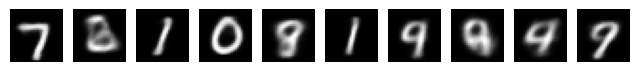

Visualizing reconstructions for fold 2


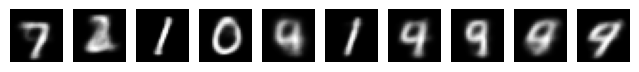

Visualizing reconstructions for fold 3


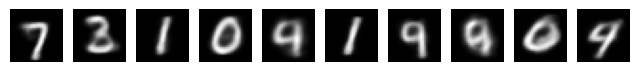

Visualizing reconstructions for fold 4


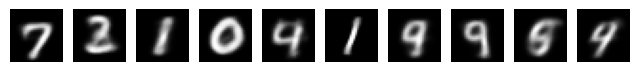

Visualizing reconstructions for fold 5


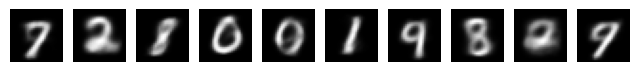

Visualizing reconstructions for fold 6


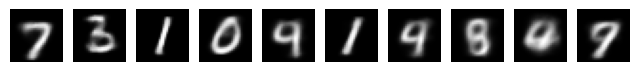

Visualizing reconstructions for fold 7


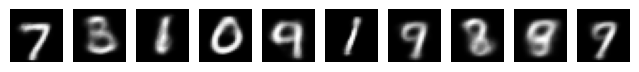

Visualizing reconstructions for fold 8


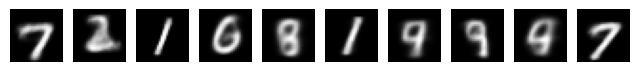

Visualizing reconstructions for fold 9


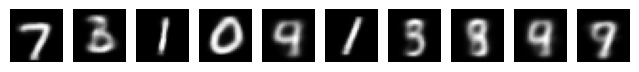

Visualizing reconstructions for fold 10


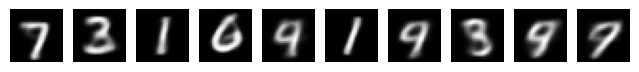

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'models_6_9.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_6_9 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_6_9):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

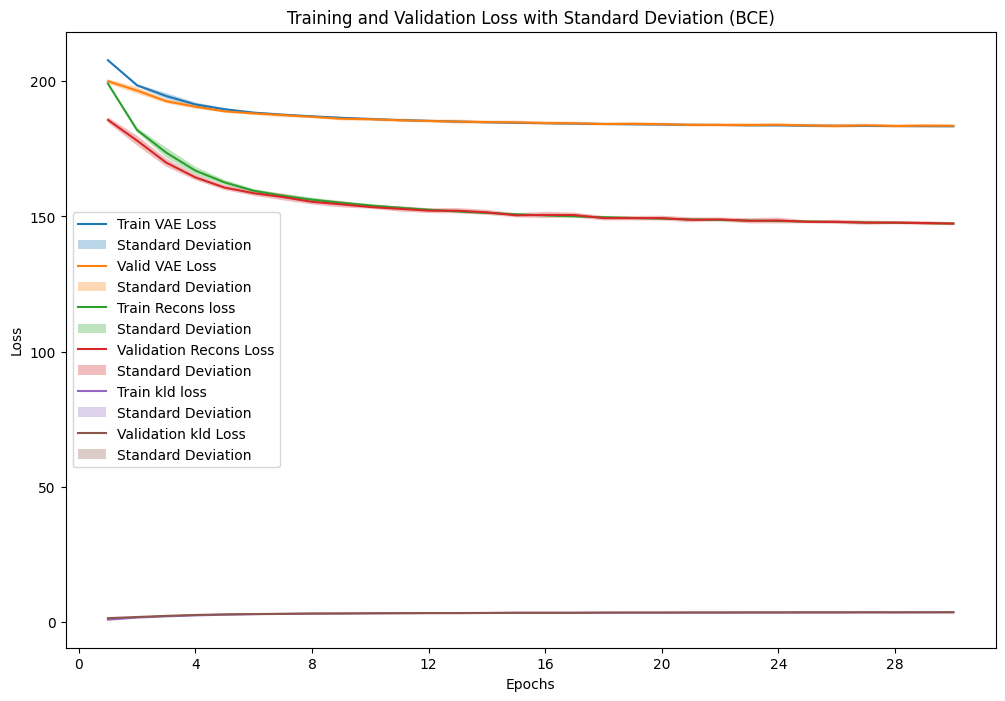

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_9.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_9 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_6_9_1 = VAE_plot_results(fold_results_6_9, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_9_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_9_1['epochs'])
    VAE_plot_mean_std(result_data_6_9_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_9_1['epochs'])
    VAE_plot_mean_std(result_data_6_9_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_9_1['epochs'])
    VAE_plot_mean_std(result_data_6_9_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_9_1['epochs'])
    VAE_plot_mean_std(result_data_6_9_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_9_1['epochs'])
    VAE_plot_mean_std(result_data_6_9_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_9_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_9_1['valid_metrics'],
    result_data_6_9_1['test_metrics'],
    result_data_6_9_1['valid_result'],
    result_data_6_9_1['test_result'],
    result_data_6_9_1['recons_valid_result'],
    result_data_6_9_1['recons_test_result'],
    result_data_6_9_1['kld_valid_result'],
    result_data_6_9_1['kld_test_result']
)


Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.188006           0.187317           183.570055     183.044028              147.396636        147.396636             3.617342       3.618777
Standard Deviation                 0.000799           0.001166             0.455065       0.161127                0.626109          0.626109             0.084146       0.079195

Detailed Evaluation Table:


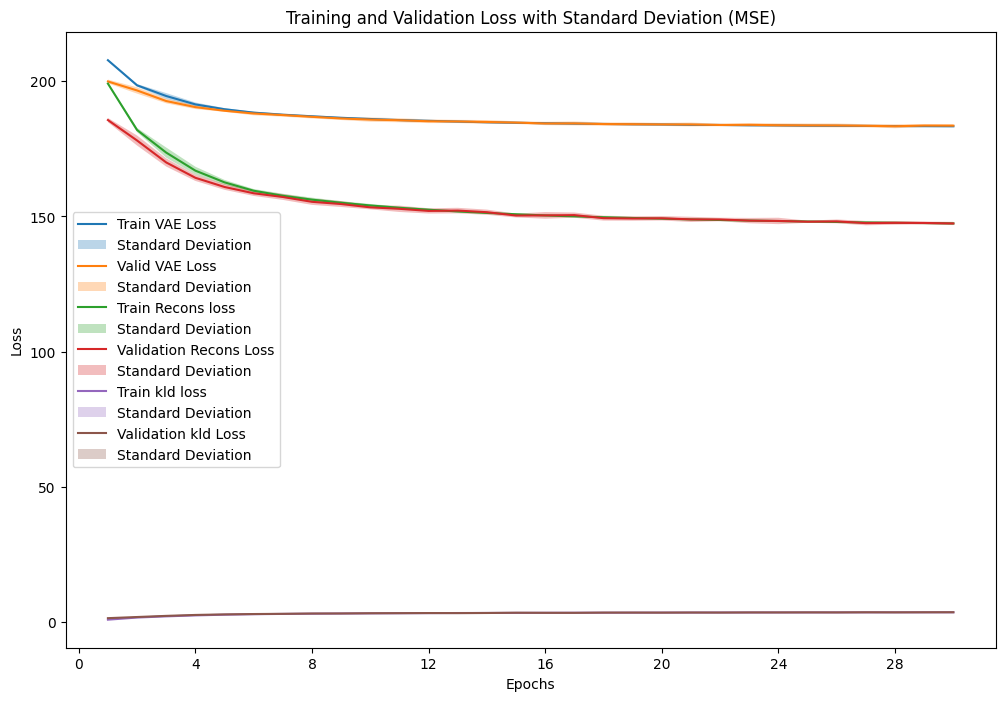

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_9.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_9 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_6_9_2 = VAE_plot_results(fold_results_6_9, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_9_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_9_2['epochs'])
    VAE_plot_mean_std(result_data_6_9_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_9_2['epochs'])
    VAE_plot_mean_std(result_data_6_9_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_9_2['epochs'])
    VAE_plot_mean_std(result_data_6_9_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_9_2['epochs'])
    VAE_plot_mean_std(result_data_6_9_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_9_2['epochs'])
    VAE_plot_mean_std(result_data_6_9_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_9_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_9_2['valid_metrics'],
    result_data_6_9_2['test_metrics'],
    result_data_6_9_2['valid_result'],
    result_data_6_9_2['test_result'],
    result_data_6_9_2['recons_valid_result'],
    result_data_6_9_2['recons_test_result'],
    result_data_6_9_2['kld_valid_result'],
    result_data_6_9_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                  0.04257           0.042396           183.647866     183.053683              147.474447        147.474447             3.617342       3.618777
Standard Deviation                  0.00032           0.000330             0.474166       0.140752                0.647110          0.647110             0.084146       0.079195

Detailed Evaluation Table:


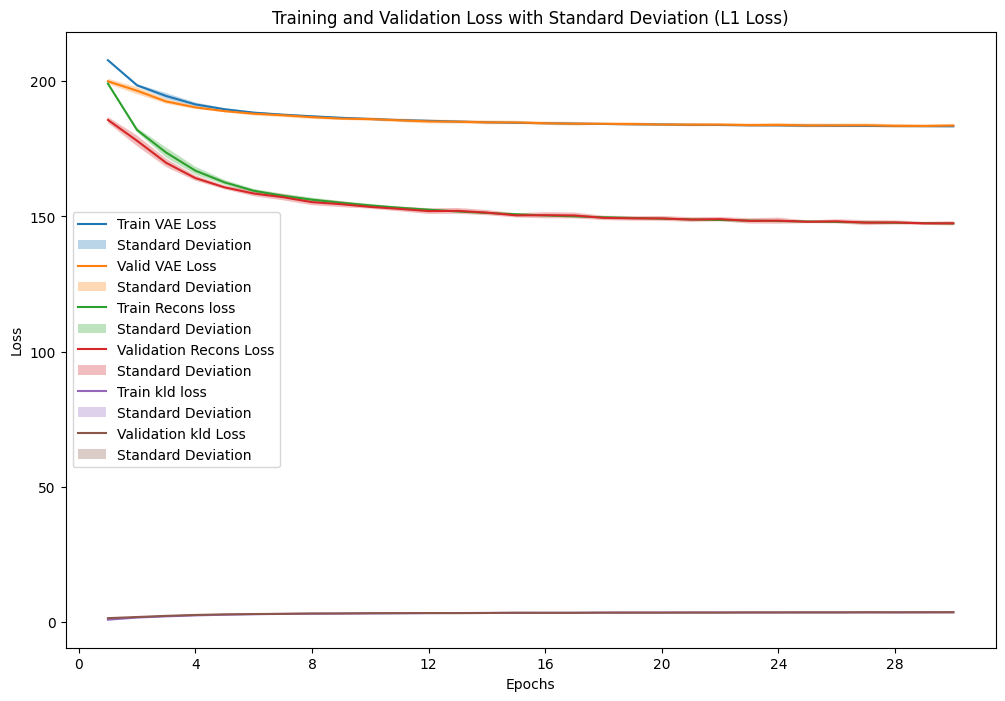

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=10/experience_1_4/'
file_path = os.path.join(directory, 'fold_results_6_9.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_6_9 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_6_9_3 = VAE_plot_results(fold_results_6_9, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_6_9_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_6_9_3['epochs'])
    VAE_plot_mean_std(result_data_6_9_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_6_9_3['epochs'])
    VAE_plot_mean_std(result_data_6_9_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_6_9_3['epochs'])
    VAE_plot_mean_std(result_data_6_9_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_6_9_3['epochs'])
    VAE_plot_mean_std(result_data_6_9_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_6_9_3['epochs'])
    VAE_plot_mean_std(result_data_6_9_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_6_9_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_6_9_3['valid_metrics'],
    result_data_6_9_3['test_metrics'],
    result_data_6_9_3['valid_result'],
    result_data_6_9_3['test_result'],
    result_data_6_9_3['recons_valid_result'],
    result_data_6_9_3['recons_test_result'],
    result_data_6_9_3['kld_valid_result'],
    result_data_6_9_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.099858           0.099831           183.497057     183.141110              147.323638        147.323638             3.617342       3.618777
Standard Deviation                 0.000252           0.000395             0.623736       0.220117                0.575611          0.575611             0.084146       0.079195

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_6_9 = sum(p.numel() for p in models_6_9[0].parameters())
print(f"Number of parameters in the model: {total_params_6_9}")

Number of parameters in the model: 748000


### Sample new data using the decoder.

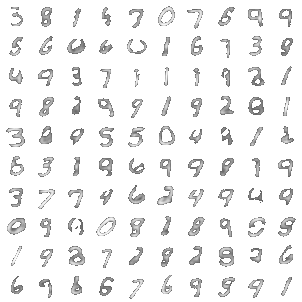

In [ ]:
sample(models_6_9[9],D_z=64)

# Table

In [ ]:
def create_dataframe(result_data, total_params_list, n_layer, dz_values):
    models_count = len(result_data)

    models = [''] * models_count
    vae_validation = [''] * models_count
    vae_testing = [''] * models_count
    total_params_per_model = [''] * models_count

    for i in range(models_count):
        mean_valid_metrics_loss = np.mean(result_data[i]['valid_metrics'])
        std_valid_metrics_loss = np.std(result_data[i]['valid_metrics'])
        mean_test_metrics_loss = np.mean(result_data[i]['test_metrics'])
        std_test_metrics_loss = np.std(result_data[i]['test_metrics'])

        models[i] = f"$D_x$: 784, $n_{{layers}}$: {n_layer[i]}, $D_z$: {dz_values[i]}"
        vae_validation[i] = f"{mean_valid_metrics_loss:.6f} ± {std_valid_metrics_loss:.6f}"
        vae_testing[i] = f"{mean_test_metrics_loss:.6f} ± {std_test_metrics_loss:.6f}"
        total_params_per_model[i] = total_params_list[i] if i < len(total_params_list) else ''

    data = pd.DataFrame({
        'Models': models,
        'VAE Validation': vae_validation,
        'VAE Testing': vae_testing,
        'Number of Parameters': total_params_per_model
    })

    return data

result_data = [
    result_data_3_1_1, result_data_3_1_2, result_data_3_1_3,
    result_data_6_2_1, result_data_6_2_2, result_data_6_2_3,
    result_data_6_3_1, result_data_6_3_2, result_data_6_3_3,
    result_data_6_4_1, result_data_6_4_2, result_data_6_4_3,
    result_data_6_6_1, result_data_6_6_2, result_data_6_6_3,
    result_data_6_7_1, result_data_6_7_2, result_data_6_7_3,
    result_data_6_8_1, result_data_6_8_2, result_data_6_8_3,
    result_data_6_9_1, result_data_6_9_2, result_data_6_9_3
]
total_params = ['', total_params_3_1, '',
                '', total_params_6_2, '',
                '', total_params_6_3, '',
                '', total_params_6_4, '',
                '', total_params_6_6,'',
                '', total_params_6_7,'',
                '', total_params_6_8,'',
                '', total_params_6_9,'']
n_layer = [1] * 12 + [2] * 12  # 12 models with n_layers = 1 and 12 models with n_layers = 2
dz_values = [2] * 3 + [16] * 3 + [32] * 3 + [64] * 3 + [2] * 3 + [16] * 3 + [32] * 3 + [64] * 3# 12 models with D_z = 1 and 12 models with D_z = 2
data = create_dataframe(result_data, total_params, n_layer, dz_values)

# Convert dataframe to LaTeX and add \hline after each first row and after the first three rows
latex_output = data.to_latex(index=False, escape=False, column_format="|c|c|c|c|")
latex_output = "\\begin{table}\n\\begin{center}\n" + latex_output + "\\caption{Training VAE with BCE table.}\n\\label{tab:table1}\n\\end{center}\n\\end{table}"
latex_output = latex_output.replace('\\toprule', '\\toprule\n\\hline', 1)  # add after first row
latex_output = latex_output.replace('\\end{tabular}', '\\hline\n\\end{tabular}', -1)  # add \hline at the end
print(latex_output)


\begin{table}
\begin{center}
\begin{tabular}{|c|c|c|c|}
\toprule
\hline
                                Models &      VAE Validation &         VAE Testing & Number of Parameters \\
\midrule
 $D_x$: 784, $n_{layers}$: 1, $D_z$: 2 & 0.239396 ± 0.000718 & 0.238776 ± 0.000397 &                      \\
 $D_x$: 784, $n_{layers}$: 1, $D_z$: 2 & 0.059920 ± 0.000200 & 0.059919 ± 0.000137 &                 5492 \\
 $D_x$: 784, $n_{layers}$: 1, $D_z$: 2 & 0.134885 ± 0.000620 & 0.135016 ± 0.000261 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 16 & 0.220910 ± 0.000841 & 0.219931 ± 0.000467 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 16 & 0.053513 ± 0.000226 & 0.053362 ± 0.000163 &                38448 \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 16 & 0.122259 ± 0.000601 & 0.122068 ± 0.000422 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 32 & 0.221134 ± 0.000807 & 0.220114 ± 0.000646 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 32 & 0.0535

<ipython-input-105-ace4dc5429d7>:52: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = data.to_latex(index=False, escape=False, column_format="|c|c|c|c|")


$$\textbf{METRIC} : BCE$$

$$
\begin{array}{c|S|r}
{\textbf{Model}}{\textbf{}} & \textbf{ $β =0.02$-VAE Validadion} & \textbf{$β =0.02$-Testing} & \textbf{Observation (overfitting)} & \textbf{$β =1$-VAE Validation} & \textbf{$β =1$-VAE Testing} & \textbf{Observation (overfitting)} & \textbf{$β =1.5$-VAE Validation} & \textbf{$β =1.5$-VAE Testing} & \textbf{Observation (overfitting)} & \textbf{$β =10$-VAE Validation} & \textbf{$β =10$-VAE Testing} & \textbf{Observation (overfitting)} & \textbf{VAE Number of Parameters} \\
\hline \\
D_x: 784, n_{layers}: 1, D_z: 2 & 0.226275 \pm 0.001036 & 0.225166 \pm 0.000662 & No & 0.227426 \pm 0.000807 & 0.226353 \pm 0.000118 & No &  0.228052 \pm  0.000902 & 0.226930 \pm 0.000231 & No & 0.239047 \pm 0.001129 & 0.238689 \pm 0.000748  & No & 5492\\
\hline \\
D_x: 784, n_{layers}: 1, D_z: 16 & 0.127615 \pm  0.000348 & 0.125684 \pm 0.000077 & No & 0.138684 \pm 0.000436 & 0.136730 \pm 0.000278 & No & 0.144070 \pm 0.000446 & 0.142173 \pm 0.000265 & No &  0.138747 \pm 0.000398 & 0.136760 \pm 0.000257 & No & 38448 \\
\hline \\
D_x: 784, n_{layers}: 1, D_z: 32 & 0.093204 \pm 0.000321 & 0.091596 \pm 0.000083 & No &  0.114784 \pm 0.000397 & 0.113037 \pm 0.000186 & No & 0.125249 \pm 0.000701& 0.123467 \pm 0.000630  & No & 0.221198 \pm 0.000950 & 0.220252 \pm 0.000617 & No & 76112\\
\hline \\
\textbf{D_x: 784, n_{layers}: 1, D_z: 64} & \textbf{ 0.073867} \pm \textbf{0.000287} & \textbf{0.072968} \pm \textbf{0.000105} & No & \textbf{0.109525} \pm \textbf{0.000464} & \textbf{0.108042} \pm \textbf{0.000376} & No & \textbf{0.123874} \pm \textbf{0.000349} & \textbf{0.122243} \pm \textbf{0.000522} & \textbf{No} & \textbf{0.221015} \pm \textbf{0.000921} & \textbf{0.220111} \pm 0.000803 & \textbf{No} & \textbf{151440}\\
\hline \\
D_x: 784, n_{layers}: 2, D_z: 2 & 0.181346 \pm  0.001216 &  0.181094 \pm 0.000885 & Yes &  0.184722 \pm 0.001426 & 0.184430 \pm 0.001378 & Yes & 0.185251 \pm  0.001356  & 0.185076 \pm 0.001369 & Yes & 0.204847 \pm 0.001291 & 0.204616 \pm 0.001091  & No & 620156\\
\hline \\
D_x: 784, n_{layers}: 2, D_z: 16 & 0.088940 \pm 0.000316 & 0.087978 \pm 0.000131 & Yes &  0.102318 \pm  0.000711 & 0.101194 \pm 0.000515 & Yes & 0.109030 \pm 0.000502 & 0.107935 \pm 0.000414 & Yes & 0.185056 \pm 0.000977 & 0.184375\pm 0.000760  & No & 648016\\
\hline \\
D_x: 784, n_{layers}: 2, D_z: 32 & 0.075699 \pm 0.000266 & 0.074949 \pm 0.000093 & Yes & 0.098988 \pm 0.000679 & 0.097934 \pm 0.000546 & Yes &  0.107636 \pm 0.000740 & 0.106483 \pm 0.000663 & Yes & 0.185831 \pm 0.001297 &  0.185198 \pm 0.000978  & No & 680576\\
\hline \\
\color{red}{D_x: 784, n_{layers}: 2, D_z: 64} & \color{red}{0.069187\pm 0.000225} & \color{red}{0.068637 \pm 0.000056 } & \color{red}{Yes} & \color{red}{ 0.099061 \pm 0.000934} & \color{red}{0.098014 \pm 0.000880} & \color{red}{Yes} & \color{red}{0.107992 \pm 0.000326} & \color{red}{0.106826 \pm 0.000498} & \color{red}{Yes} & 0.188006 \pm 0.000799 & 0.187317 \pm  0.001166 & \color{red}{No} & \color{red}{748000} \\
\hline
\end{array}
$$